In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Download data from Kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'garbage-classification-v2' dataset.
Path to dataset files: /kaggle/input/garbage-classification-v2


In [3]:
data_path = path + "/garbage-dataset"

## Copy dataset

In [4]:
# Copy dataset từ thư mục read-only sang thư mục có quyền ghi
import os
import shutil

# Tạo thư mục mới trong /content/ (có quyền ghi trên Google Colab)
original_data_path = data_path  # Lưu đường dẫn gốc
processed_data_path = "/content/garbage-dataset-processed"

# Xóa thư mục cũ nếu đã tồn tại
if os.path.exists(processed_data_path):
    print(f"Removing existing directory: {processed_data_path}")
    shutil.rmtree(processed_data_path)

print(f"Copying dataset from {original_data_path} to {processed_data_path}...")
print("This may take a few minutes...")

# Copy toàn bộ dataset
shutil.copytree(original_data_path, processed_data_path)

print("✓ Copy completed!")
print(f"Original path (read-only): {original_data_path}")
print(f"New path (writable): {processed_data_path}")

# Cập nhật data_path để sử dụng thư mục mới
data_path = processed_data_path
print(f"\nUpdated data_path: {data_path}")


Copying dataset from /kaggle/input/garbage-classification-v2/garbage-dataset to /content/garbage-dataset-processed...
This may take a few minutes...
✓ Copy completed!
Original path (read-only): /kaggle/input/garbage-classification-v2/garbage-dataset
New path (writable): /content/garbage-dataset-processed

Updated data_path: /content/garbage-dataset-processed


## 1. EDA

In [5]:
import os
import pandas as pd

classes = sorted(os.listdir(data_path))
print("Classes:", classes)

img_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in classes}
df_counts = pd.DataFrame.from_dict(img_counts, orient="index", columns=["num_images"])

df_counts

Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


,num_images
battery,944
biological,997
cardboard,1825
clothes,5327
glass,3061
metal,1020
paper,1680
plastic,1984
shoes,1977
trash,947


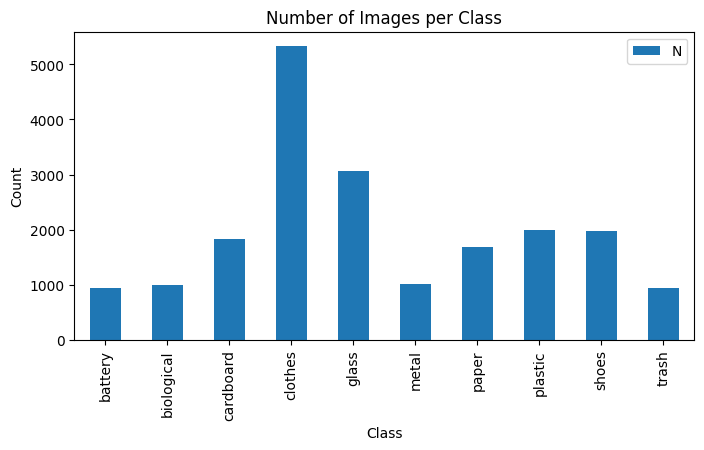

In [6]:
import matplotlib.pyplot as plt

df_counts.plot(kind="bar", figsize=(8,4))
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend('Number of images')
plt.show()

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import math
import random
import os

num_classes = len(classes)

# Automatically compute grid size
cols = 3
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(15, 5 * rows))

for i, cls in enumerate(classes):
    class_path = os.path.join(data_path, cls)
    img_name = random.choice(os.listdir(class_path))
    img = Image.open(os.path.join(class_path, img_name))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [8]:
from PIL import Image
import numpy as np

sizes = []

for cls in classes:
  class_path = os.path.join(data_path, cls)
  imgs = os.listdir(class_path)
  for img_name in imgs:
    img = Image.open(os.path.join(class_path, img_name))
    sizes.append(img.size)

sizes = np.array(sizes)
print("Min size:", sizes.min(axis=0))
print("Max size:", sizes.max(axis=0))
print("Average size:", sizes.mean(axis=0))

Min size: [51 71]
Max size: [7786 6283]
Average size: [420.79880579 431.64290052]


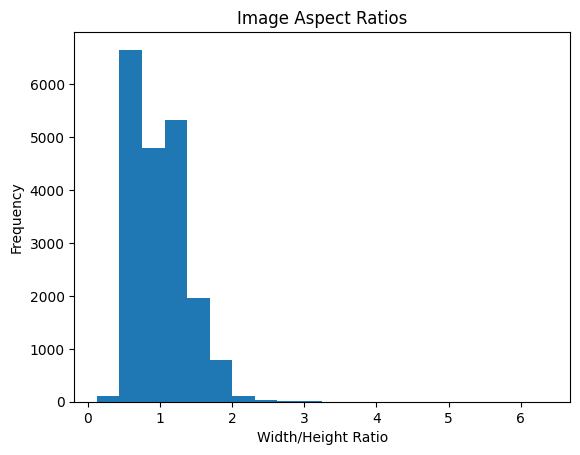

In [9]:
# Kiem tra crop/stretch
ratios = [w/h for (w, h) in sizes]
plt.hist(ratios, bins=20)
plt.title("Image Aspect Ratios")
plt.xlabel("Width/Height Ratio")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Kiem tra anh loi
corrupt = []

for cls in classes:
    folder = os.path.join(data_path, cls)
    for fname in os.listdir(folder):
        try:
            Image.open(os.path.join(folder, fname)).verify()
        except:
            corrupt.append(os.path.join(cls, fname))

corrupt, len(corrupt)

([], 0)

## 2. Data Cleaning

In [11]:
# Xóa ảnh trùng lặp và ảnh không liên quan
import hashlib

def get_image_hash(image_path):
    """Tính hash của ảnh để phát hiện trùng lặp"""
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

def clean_dataset(data_path, classes, min_size=(50, 50), max_size=(5000, 5000)):
    """
    Làm sạch dataset:
    - Xóa ảnh trùng lặp (dựa trên hash) - chỉ trong cùng một class
    - Xóa ảnh có kích thước không hợp lệ
    - Xóa ảnh lỗi (đã kiểm tra ở cell trước)
    """
    removed_duplicates = 0
    removed_invalid_size = 0
    removed_corrupt = 0

    print("Starting data cleaning...")

    for cls in classes:
        class_path = os.path.join(data_path, cls)
        if not os.path.exists(class_path):
            continue

        # Dictionary để lưu hash cho mỗi class (reset cho mỗi class)
        hash_dict = {}

        print(f"\nProcessing class: {cls}")
        image_files = os.listdir(class_path)
        initial_count = len(image_files)

        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)

            try:
                # Kiểm tra ảnh có mở được không
                img = Image.open(img_path)
                img.verify()  # Verify image
                img = Image.open(img_path)  # Reopen after verify

                # Kiểm tra kích thước
                width, height = img.size
                if width < min_size[0] or height < min_size[1]:
                    os.remove(img_path)
                    removed_invalid_size += 1
                    continue
                if width > max_size[0] or height > max_size[1]:
                    os.remove(img_path)
                    removed_invalid_size += 1
                    continue

                # Tính hash để phát hiện trùng lặp (chỉ trong cùng class)
                img_hash = get_image_hash(img_path)
                if img_hash:
                    # Nếu hash đã tồn tại, xóa ảnh này (giữ ảnh đầu tiên)
                    if img_hash in hash_dict:
                        os.remove(img_path)
                        removed_duplicates += 1
                    else:
                        hash_dict[img_hash] = img_path  # Lưu ảnh đầu tiên

            except Exception as e:
                # Xóa ảnh lỗi
                try:
                    os.remove(img_path)
                    removed_corrupt += 1
                except:
                    pass

        final_count = len(os.listdir(class_path))
        print(f"  Initial: {initial_count}, Final: {final_count}, Removed: {initial_count - final_count}")

    print(f"\n=== Cleaning Summary ===")
    print(f"Removed duplicates: {removed_duplicates}")
    print(f"Removed invalid size: {removed_invalid_size}")
    print(f"Removed corrupt images: {removed_corrupt}")
    print(f"Total removed: {removed_duplicates + removed_invalid_size + removed_corrupt}")

    return removed_duplicates, removed_invalid_size, removed_corrupt

# Thực hiện làm sạch dữ liệu
removed_dup, removed_size, removed_corr = clean_dataset(
    data_path,
    classes,
    min_size=(50, 50),  # Ảnh quá nhỏ (< 50x50)
    max_size=(5000, 5000)  # Ảnh quá lớn (> 5000x5000)
)


Starting data cleaning...

Processing class: battery
  Initial: 944, Final: 944, Removed: 0

Processing class: biological
  Initial: 997, Final: 997, Removed: 0

Processing class: cardboard
  Initial: 1825, Final: 1825, Removed: 0

Processing class: clothes
  Initial: 5327, Final: 5327, Removed: 0

Processing class: glass
  Initial: 3061, Final: 3060, Removed: 1

Processing class: metal
  Initial: 1020, Final: 1020, Removed: 0

Processing class: paper
  Initial: 1680, Final: 1680, Removed: 0

Processing class: plastic
  Initial: 1984, Final: 1981, Removed: 3

Processing class: shoes
  Initial: 1977, Final: 1977, Removed: 0

Processing class: trash
  Initial: 947, Final: 947, Removed: 0

=== Cleaning Summary ===
Removed duplicates: 0
Removed invalid size: 4
Removed corrupt images: 0
Total removed: 4


## 3. Image Resizing

In [12]:
# Chuẩn hóa kích thước tất cả ảnh về 224x224
from tqdm import tqdm

def resize_images_to_224x224(data_path, classes, target_size=(224, 224), save_path=None):
    """
    Resize tất cả ảnh về kích thước 224x224
    - Nếu save_path được chỉ định, lưu vào thư mục mới
    - Nếu không, ghi đè lên ảnh cũ
    """
    if save_path is None:
        save_path = data_path
        overwrite = True
    else:
        overwrite = False
        os.makedirs(save_path, exist_ok=True)

    total_resized = 0
    failed = 0

    print(f"Resizing images to {target_size}...")
    print(f"Save path: {save_path}")
    print(f"Overwrite original: {overwrite}\n")

    for cls in classes:
        class_path = os.path.join(data_path, cls)
        if not os.path.exists(class_path):
            continue

        # Tạo thư mục mới nếu không ghi đè
        if not overwrite:
            new_class_path = os.path.join(save_path, cls)
            os.makedirs(new_class_path, exist_ok=True)
        else:
            new_class_path = class_path

        image_files = os.listdir(class_path)
        print(f"Processing class: {cls} ({len(image_files)} images)")

        for img_name in tqdm(image_files, desc=f"  {cls}"):
            img_path = os.path.join(class_path, img_name)
            new_img_path = os.path.join(new_class_path, img_name)

            try:
                # Mở ảnh
                img = Image.open(img_path)

                # Chuyển sang RGB nếu cần (xử lý ảnh RGBA, L, P, etc.)
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Resize về 224x224 (sử dụng LANCZOS để chất lượng tốt hơn)
                img_resized = img.resize(target_size, Image.Resampling.LANCZOS)

                # Lưu ảnh
                img_resized.save(new_img_path, 'JPEG', quality=95)
                total_resized += 1

            except Exception as e:
                print(f"  Failed to resize {img_name}: {str(e)}")
                failed += 1
                continue

    print(f"\n=== Resize Summary ===")
    print(f"Total resized: {total_resized}")
    print(f"Failed: {failed}")

    return total_resized, failed

# Thực hiện resize về 224x224
# Lưu vào cùng thư mục (ghi đè) vì đã copy sang thư mục có quyền ghi
total_resized, failed = resize_images_to_224x224(
    data_path,
    classes,
    target_size=(224, 224),
    save_path=None  # None = ghi đè lên ảnh trong data_path (đã có quyền ghi)
)


Resizing images to (224, 224)...
Save path: /content/garbage-dataset-processed
Overwrite original: True

Processing class: battery (944 images)


  battery: 100%|██████████| 944/944 [00:02<00:00, 414.05it/s]


Processing class: biological (997 images)


  biological: 100%|██████████| 997/997 [00:02<00:00, 367.08it/s]


Processing class: cardboard (1825 images)


  cardboard: 100%|██████████| 1825/1825 [00:16<00:00, 112.16it/s]


Processing class: clothes (5327 images)


  clothes: 100%|██████████| 5327/5327 [00:34<00:00, 153.99it/s]


Processing class: glass (3060 images)


  glass: 100%|██████████| 3060/3060 [00:24<00:00, 123.76it/s]


Processing class: metal (1020 images)


  metal: 100%|██████████| 1020/1020 [00:05<00:00, 190.85it/s]


Processing class: paper (1680 images)


  paper: 100%|██████████| 1680/1680 [00:17<00:00, 95.39it/s] 


Processing class: plastic (1981 images)


  plastic: 100%|██████████| 1981/1981 [00:27<00:00, 73.17it/s]


Processing class: shoes (1977 images)


  shoes: 100%|██████████| 1977/1977 [00:06<00:00, 309.81it/s]


Processing class: trash (947 images)


  trash: 100%|██████████| 947/947 [00:05<00:00, 177.30it/s]


=== Resize Summary ===
Total resized: 19758
Failed: 0


In [13]:
# Kiểm tra lại số lượng ảnh sau khi làm sạch và resize
import pandas as pd

print("Dataset statistics after cleaning and resizing:")
print("=" * 50)

new_img_counts = {}
for cls in classes:
    class_path = os.path.join(data_path, cls)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
        new_img_counts[cls] = count
    else:
        new_img_counts[cls] = 0

df_new_counts = pd.DataFrame.from_dict(new_img_counts, orient="index", columns=["num_images"])
print(df_new_counts)

# So sánh với trước khi làm sạch
if 'df_counts' in globals():
    print("\nComparison (Before vs After):")
    comparison = pd.DataFrame({
        'Before': df_counts['num_images'],
        'After': df_new_counts['num_images']
    })
    comparison['Removed'] = comparison['Before'] - comparison['After']
    comparison['Removed %'] = (comparison['Removed'] / comparison['Before'] * 100).round(2)
    print(comparison)

# Kiểm tra kích thước ảnh sau khi resize
sample_sizes = []
for cls in classes:
    class_path = os.path.join(data_path, cls)
    if os.path.exists(class_path):
        img_files = [f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        if img_files:
            sample_img = Image.open(os.path.join(class_path, img_files[0]))
            sample_sizes.append(sample_img.size)

if sample_sizes:
    print(f"\nSample image sizes after resize: {set(sample_sizes)}")
    print("All images should be 224x224 ✓")


Dataset statistics after cleaning and resizing:
            num_images
battery            944
biological         997
cardboard         1825
clothes           5327
glass             3060
metal             1020
paper             1680
plastic           1981
shoes             1977
trash              947

Comparison (Before vs After):
            Before  After  Removed  Removed %
battery        944    944        0       0.00
biological     997    997        0       0.00
cardboard     1825   1825        0       0.00
clothes       5327   5327        0       0.00
glass         3061   3060        1       0.03
metal         1020   1020        0       0.00
paper         1680   1680        0       0.00
plastic       1984   1981        3       0.15
shoes         1977   1977        0       0.00
trash          947    947        0       0.00

Sample image sizes after resize: {(224, 224)}
All images should be 224x224 ✓


## 4. Data Augmentation

In [14]:
# Data Augmentation với các kỹ thuật đa dạng
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageOps

def rotate_image(img, angle_range=(-20, 20)):
    """Xoay ảnh với góc ngẫu nhiên trong khoảng ±15-20 độ"""
    angle = random.uniform(angle_range[0], angle_range[1])
    # Sử dụng background màu đen thay vì xám để tự nhiên hơn
    # Hoặc có thể crop để loại bỏ background
    rotated = img.rotate(angle, resample=Image.Resampling.BILINEAR, expand=False, fillcolor=(0, 0, 0))
    return rotated

def horizontal_flip(img):
    """Lật ngang ảnh"""
    return img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

def translate_image(img, max_translate_percent=(0.1, 0.2)):
    """Dịch chuyển ảnh tối đa 10-20% chiều ảnh"""
    width, height = img.size
    max_tx = int(width * random.uniform(max_translate_percent[0], max_translate_percent[1]))
    max_ty = int(height * random.uniform(max_translate_percent[0], max_translate_percent[1]))

    tx = random.randint(-max_tx, max_tx)
    ty = random.randint(-max_ty, max_ty)

    # Sử dụng background màu đen thay vì xám
    new_img = Image.new('RGB', (width, height), (0, 0, 0))
    new_img.paste(img, (tx, ty))
    return new_img

def adjust_brightness(img, brightness_range=(0.7, 1.3)):
    """Thay đổi độ sáng ±20-30%"""
    brightness_factor = random.uniform(brightness_range[0], brightness_range[1])
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(brightness_factor)

def adjust_contrast(img, contrast_range=(0.8, 1.2)):
    """Thay đổi độ tương phản ±20%"""
    contrast_factor = random.uniform(contrast_range[0], contrast_range[1])
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(contrast_factor)

def zoom_image(img, zoom_range=(0.8, 1.2)):
    """Zoom in/out ảnh từ 0.8 đến 1.2"""
    zoom_factor = random.uniform(zoom_range[0], zoom_range[1])
    width, height = img.size

    # Tính kích thước mới
    new_width = int(width * zoom_factor)
    new_height = int(height * zoom_factor)

    # Resize ảnh
    zoomed_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Crop hoặc pad để giữ nguyên kích thước gốc
    if zoom_factor > 1.0:  # Zoom in - cần crop
        left = (new_width - width) // 2
        top = (new_height - height) // 2
        zoomed_img = zoomed_img.crop((left, top, left + width, top + height))
    else:  # Zoom out - sử dụng background màu đen
        new_img = Image.new('RGB', (width, height), (0, 0, 0))
        left = (width - new_width) // 2
        top = (height - new_height) // 2
        new_img.paste(zoomed_img, (left, top))
        zoomed_img = new_img

    return zoomed_img

def shear_image(img, shear_range=(-0.1, 0.1)):
    """Làm biến dạng ảnh (shear) theo trục X hoặc Y"""
    width, height = img.size
    shear_x = random.uniform(shear_range[0], shear_range[1])
    shear_y = random.uniform(shear_range[0], shear_range[1])

    # Tạo ma trận biến đổi affine
    # Shear transformation matrix
    matrix = [1, shear_x, 0, shear_y, 1, 0]
    sheared = img.transform(img.size, Image.Transform.AFFINE, matrix,
                           resample=Image.Resampling.BILINEAR, fillcolor=(0, 0, 0))
    return sheared

def add_noise(img, noise_factor=0.05):
    """Thêm noise nhẹ vào ảnh"""
    img_array = np.array(img).astype(np.float32)
    noise = np.random.normal(0, noise_factor * 255, img_array.shape)
    noisy_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_array)

def color_jitter(img, brightness=0.2, contrast=0.2, saturation=0.2):
    """Kết hợp thay đổi brightness, contrast và saturation"""
    # Brightness
    if random.random() < 0.5:
        img = adjust_brightness(img, brightness_range=(1-brightness, 1+brightness))
    # Contrast
    if random.random() < 0.5:
        img = adjust_contrast(img, contrast_range=(1-contrast, 1+contrast))
    # Saturation
    if random.random() < 0.5:
        saturation_factor = random.uniform(1-saturation, 1+saturation)
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(saturation_factor)
    return img

def apply_random_augmentation(img, augmentation_list, combine_probability=0.3):
    """
    Áp dụng augmentation ngẫu nhiên từ danh sách
    - combine_probability: Xác suất kết hợp nhiều augmentation (0.3 = 30%)
    """
    # Có thể kết hợp nhiều augmentation để tăng đa dạng
    if random.random() < combine_probability:
        # Kết hợp 2 augmentation
        aug_func1 = random.choice(augmentation_list)
        aug_func2 = random.choice(augmentation_list)
        # Đảm bảo không chọn cùng một augmentation
        while aug_func1 == aug_func2:
            aug_func2 = random.choice(augmentation_list)
        img = aug_func1(img)
        img = aug_func2(img)
        return img
    else:
        # Chỉ áp dụng 1 augmentation
        aug_func = random.choice(augmentation_list)
        return aug_func(img)

# Danh sách các hàm augmentation cơ bản
basic_augmentation_functions = [
    lambda img: rotate_image(img, angle_range=(-20, 20)),
    horizontal_flip,
    lambda img: translate_image(img, max_translate_percent=(0.1, 0.2)),
    lambda img: adjust_brightness(img, brightness_range=(0.7, 1.3)),
    lambda img: adjust_contrast(img, contrast_range=(0.8, 1.2)),
    lambda img: zoom_image(img, zoom_range=(0.8, 1.2))
]

# Danh sách đầy đủ bao gồm augmentation nâng cao
augmentation_functions = [
    lambda img: rotate_image(img, angle_range=(-20, 20)),
    horizontal_flip,
    lambda img: translate_image(img, max_translate_percent=(0.1, 0.2)),
    lambda img: adjust_brightness(img, brightness_range=(0.7, 1.3)),
    lambda img: adjust_contrast(img, contrast_range=(0.8, 1.2)),
    lambda img: zoom_image(img, zoom_range=(0.8, 1.2)),
    lambda img: shear_image(img, shear_range=(-0.1, 0.1)),
    lambda img: color_jitter(img, brightness=0.2, contrast=0.2, saturation=0.2),
    lambda img: add_noise(img, noise_factor=0.03)  # Noise nhẹ
]

print("Augmentation functions defined:")
print("1. Rotate: ±15-20 degrees")
print("2. Horizontal flip")
print("3. Translation: 10-20% of image size")
print("4. Brightness: ±20-30%")
print("5. Contrast: ±20%")
print("6. Zoom: 0.8 to 1.2")
print("7. Shear: ±10% (NEW)")
print("8. Color Jitter: brightness + contrast + saturation (NEW)")
print("9. Noise: Light noise (NEW)")
print("\nNote: 30% chance to combine 2 augmentations for more diversity")


Augmentation functions defined:
1. Rotate: ±15-20 degrees
2. Horizontal flip
3. Translation: 10-20% of image size
4. Brightness: ±20-30%
5. Contrast: ±20%
6. Zoom: 0.8 to 1.2
7. Shear: ±10% (NEW)
8. Color Jitter: brightness + contrast + saturation (NEW)
9. Noise: Light noise (NEW)

Note: 30% chance to combine 2 augmentations for more diversity


In [15]:
# Áp dụng augmentation cho dataset với các cải thiện
def augment_dataset(data_path, classes, output_path, augmentations_per_image=2, use_advanced=True):
    """
    Áp dụng augmentation cho dataset
    - augmentations_per_image: Số lượng ảnh augmented tạo ra từ mỗi ảnh gốc
    - use_advanced: Sử dụng danh sách augmentation đầy đủ (9 loại) hay chỉ cơ bản (6 loại)
    """
    # Chọn danh sách augmentation
    aug_list = augmentation_functions if use_advanced else basic_augmentation_functions
    os.makedirs(output_path, exist_ok=True)

    total_original = 0
    total_augmented = 0

    print(f"Starting augmentation...")
    print(f"Augmentations per image: {augmentations_per_image}")
    print(f"Output path: {output_path}\n")

    for cls in classes:
        class_path = os.path.join(data_path, cls)
        if not os.path.exists(class_path):
            continue

        output_class_path = os.path.join(output_path, cls)
        os.makedirs(output_class_path, exist_ok=True)

        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        print(f"Processing class: {cls} ({len(image_files)} images)")
        class_augmented = 0

        for img_name in tqdm(image_files, desc=f"  {cls}"):
            img_path = os.path.join(class_path, img_name)

            try:
                # Mở ảnh gốc
                img = Image.open(img_path)

                # Đảm bảo ảnh là RGB
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Copy ảnh gốc sang thư mục output (nếu muốn giữ ảnh gốc)
                base_name = os.path.splitext(img_name)[0]
                ext = os.path.splitext(img_name)[1]
                original_output_path = os.path.join(output_class_path, img_name)
                img.save(original_output_path, 'JPEG', quality=95)
                total_original += 1

                # Tạo các ảnh augmented
                for aug_idx in range(augmentations_per_image):
                    # Áp dụng augmentation ngẫu nhiên (có thể kết hợp 2 augmentation)
                    augmented_img = apply_random_augmentation(img, aug_list, combine_probability=0.3)

                    # Lưu ảnh augmented
                    aug_name = f"{base_name}_aug{aug_idx+1}{ext}"
                    aug_output_path = os.path.join(output_class_path, aug_name)
                    augmented_img.save(aug_output_path, 'JPEG', quality=95)
                    class_augmented += 1
                    total_augmented += 1

            except Exception as e:
                print(f"  Failed to augment {img_name}: {str(e)}")
                continue

        print(f"  Original: {len(image_files)}, Augmented: {class_augmented}, Total: {len(image_files) + class_augmented}\n")

    print(f"=== Augmentation Summary ===")
    print(f"Total original images: {total_original}")
    print(f"Total augmented images: {total_augmented}")
    print(f"Total images after augmentation: {total_original + total_augmented}")
    print(f"Augmentation ratio: {total_augmented / total_original:.2f}x")

    return total_original, total_augmented

# Thực hiện augmentation
# Tạo dataset mới với augmentation (hoặc có thể ghi đè dataset cũ)
augmented_data_path = "/content/garbage-dataset-augmented"

original_count, augmented_count = augment_dataset(
    data_path,
    classes,
    output_path=augmented_data_path,
    augmentations_per_image=2,  # Tạo 2 ảnh augmented từ mỗi ảnh gốc
    use_advanced=True  # Sử dụng augmentation nâng cao (9 loại + kết hợp)
)


Starting augmentation...
Augmentations per image: 2
Output path: /content/garbage-dataset-augmented

Processing class: battery (944 images)


  battery: 100%|██████████| 944/944 [00:04<00:00, 199.93it/s]


  Original: 944, Augmented: 1888, Total: 2832

Processing class: biological (997 images)


  biological: 100%|██████████| 997/997 [00:05<00:00, 196.86it/s]


  Original: 997, Augmented: 1994, Total: 2991

Processing class: cardboard (1825 images)


  cardboard: 100%|██████████| 1825/1825 [00:10<00:00, 176.10it/s]


  Original: 1825, Augmented: 3650, Total: 5475

Processing class: clothes (5327 images)


  clothes: 100%|██████████| 5327/5327 [00:30<00:00, 173.00it/s]


  Original: 5327, Augmented: 10654, Total: 15981

Processing class: glass (3060 images)


  glass: 100%|██████████| 3060/3060 [00:17<00:00, 172.50it/s]


  Original: 3060, Augmented: 6120, Total: 9180

Processing class: metal (1020 images)


  metal: 100%|██████████| 1020/1020 [00:05<00:00, 195.99it/s]


  Original: 1020, Augmented: 2040, Total: 3060

Processing class: paper (1680 images)


  paper: 100%|██████████| 1680/1680 [00:11<00:00, 150.01it/s]


  Original: 1680, Augmented: 3360, Total: 5040

Processing class: plastic (1981 images)


  plastic: 100%|██████████| 1981/1981 [00:11<00:00, 175.69it/s]


  Original: 1981, Augmented: 3962, Total: 5943

Processing class: shoes (1977 images)


  shoes: 100%|██████████| 1977/1977 [00:11<00:00, 170.62it/s]


  Original: 1977, Augmented: 3954, Total: 5931

Processing class: trash (947 images)


  trash: 100%|██████████| 947/947 [00:04<00:00, 191.35it/s]

  Original: 947, Augmented: 1894, Total: 2841

=== Augmentation Summary ===
Total original images: 19758
Total augmented images: 39516
Total images after augmentation: 59274
Augmentation ratio: 2.00x


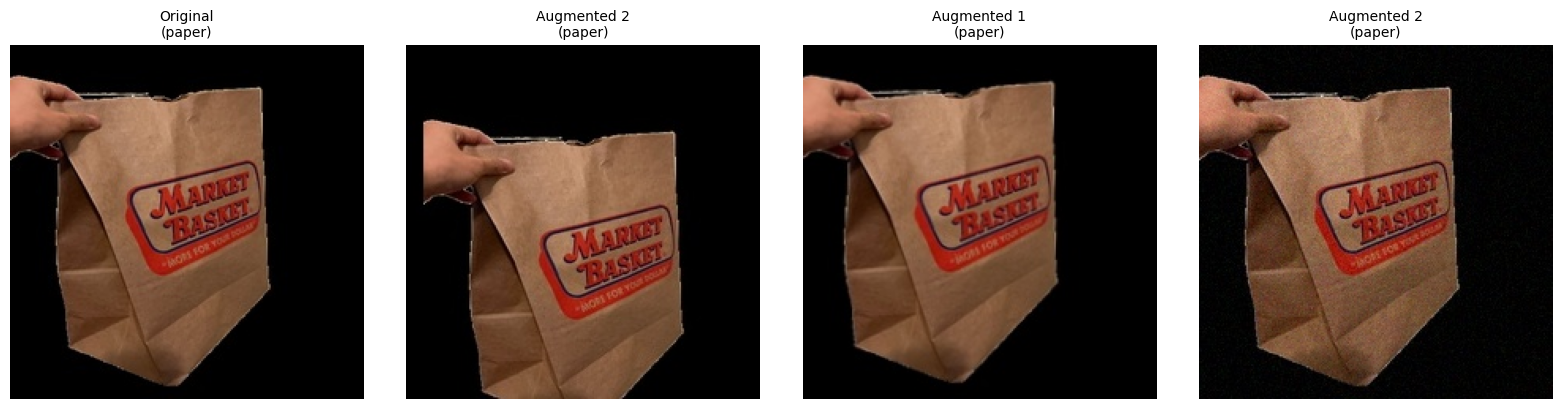

In [16]:
# Hiển thị ví dụ các ảnh đã được augmentation
import matplotlib.pyplot as plt
import random

# Chọn một class và một ảnh ngẫu nhiên để hiển thị
sample_class = random.choice(classes)
sample_class_path = os.path.join(augmented_data_path, sample_class)

if os.path.exists(sample_class_path):
    image_files = [f for f in os.listdir(sample_class_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    if len(image_files) >= 4:
        # Tìm ảnh gốc và các ảnh augmented của nó
        base_names = {}
        for img_name in image_files:
            if '_aug' not in img_name:
                base_name = os.path.splitext(img_name)[0]
                base_names[base_name] = [img_name]

        # Tìm các ảnh augmented
        for img_name in image_files:
            if '_aug' in img_name:
                base_name = img_name.split('_aug')[0]
                if base_name in base_names:
                    base_names[base_name].append(img_name)

        # Chọn một ảnh có đủ augmented versions
        selected_base = None
        for base, files in base_names.items():
            if len(files) >= 4:  # 1 gốc + 3 augmented
                selected_base = base
                break

        if selected_base:
            files_to_show = base_names[selected_base][:4]  # Lấy 4 ảnh đầu tiên

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            for idx, img_name in enumerate(files_to_show):
                img_path = os.path.join(sample_class_path, img_name)
                img = Image.open(img_path)

                axes[idx].imshow(img)
                if idx == 0:
                    axes[idx].set_title(f"Original\n({sample_class})", fontsize=10)
                else:
                    aug_type = img_name.split('_aug')[1].split('.')[0]
                    axes[idx].set_title(f"Augmented {aug_type}\n({sample_class})", fontsize=10)
                axes[idx].axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("Not enough augmented images found for visualization")
    else:
        print(f"Not enough images in {sample_class} class")
else:
    print(f"Path {sample_class_path} does not exist")


## 5. Train/Val/Test Split

In [17]:
# Chia tập dữ liệu: Train 70%, Validation 15%, Test 15%
# Đảm bảo phân bố đều các lớp (stratified split)
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm

def split_dataset(source_path, classes, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Chia dataset thành train, validation, test với phân bố đều các lớp

    Parameters:
    - source_path: Đường dẫn đến dataset gốc (đã được augmentation)
    - classes: Danh sách các lớp
    - train_ratio: Tỷ lệ train (mặc định 0.7 = 70%)
    - val_ratio: Tỷ lệ validation (mặc định 0.15 = 15%)
    - test_ratio: Tỷ lệ test (mặc định 0.15 = 15%)
    - random_state: Seed để đảm bảo kết quả có thể tái tạo
    """
    # Kiểm tra tỷ lệ
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.001, "Tỷ lệ phải tổng bằng 1.0"

    # Tạo thư mục output
    base_output_path = "/content/garbage-dataset-split"
    train_path = os.path.join(base_output_path, "train")
    val_path = os.path.join(base_output_path, "validation")
    test_path = os.path.join(base_output_path, "test")

    # Xóa thư mục cũ nếu tồn tại
    if os.path.exists(base_output_path):
        print(f"Removing existing split directory: {base_output_path}")
        shutil.rmtree(base_output_path)

    # Tạo thư mục mới
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    print(f"Splitting dataset from: {source_path}")
    print(f"Train: {train_ratio*100}%, Validation: {val_ratio*100}%, Test: {test_ratio*100}%")
    print(f"Random state: {random_state}\n")

    total_train = 0
    total_val = 0
    total_test = 0

    for cls in classes:
        class_path = os.path.join(source_path, cls)
        if not os.path.exists(class_path):
            continue

        # Lấy danh sách tất cả ảnh trong class
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        if len(image_files) == 0:
            continue

        # Tạo labels (tất cả cùng một class)
        labels = [cls] * len(image_files)

        # Chia thành train và temp (val + test)
        # Tính tỷ lệ: temp = val + test = 1 - train
        temp_ratio = val_ratio + test_ratio
        X_train, X_temp, y_train, y_temp = train_test_split(
            image_files, labels,
            test_size=temp_ratio,
            stratify=labels,  # Đảm bảo phân bố đều
            random_state=random_state
        )

        # Chia temp thành validation và test
        # Tỷ lệ: val / (val + test)
        val_in_temp_ratio = val_ratio / temp_ratio
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=(1 - val_in_temp_ratio),  # test = 1 - val_in_temp
            stratify=y_temp,  # Đảm bảo phân bố đều
            random_state=random_state
        )

        # Tạo thư mục cho từng tập
        train_class_path = os.path.join(train_path, cls)
        val_class_path = os.path.join(val_path, cls)
        test_class_path = os.path.join(test_path, cls)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Copy ảnh vào các thư mục tương ứng
        print(f"Processing class: {cls}")
        print(f"  Total: {len(image_files)}, Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

        # Copy train
        for img_name in tqdm(X_train, desc=f"  Copying train", leave=False):
            src = os.path.join(class_path, img_name)
            dst = os.path.join(train_class_path, img_name)
            shutil.copy2(src, dst)
            total_train += 1

        # Copy validation
        for img_name in tqdm(X_val, desc=f"  Copying val", leave=False):
            src = os.path.join(class_path, img_name)
            dst = os.path.join(val_class_path, img_name)
            shutil.copy2(src, dst)
            total_val += 1

        # Copy test
        for img_name in tqdm(X_test, desc=f"  Copying test", leave=False):
            src = os.path.join(class_path, img_name)
            dst = os.path.join(test_class_path, img_name)
            shutil.copy2(src, dst)
            total_test += 1

        print()

    print("=" * 60)
    print("Split Summary:")
    print(f"  Train: {total_train} images ({total_train/(total_train+total_val+total_test)*100:.1f}%)")
    print(f"  Validation: {total_val} images ({total_val/(total_train+total_val+total_test)*100:.1f}%)")
    print(f"  Test: {total_test} images ({total_test/(total_train+total_val+total_test)*100:.1f}%)")
    print(f"  Total: {total_train + total_val + total_test} images")
    print("=" * 60)

    return train_path, val_path, test_path

# Thực hiện chia dataset
# Sử dụng dataset đã được augmentation
split_train_path, split_val_path, split_test_path = split_dataset(
    source_path=augmented_data_path,  # Dataset đã được augmentation
    classes=classes,
    train_ratio=0.7,    # 70%
    val_ratio=0.15,      # 15%
    test_ratio=0.15,    # 15%
    random_state=42     # Đảm bảo kết quả có thể tái tạo
)


Splitting dataset from: /content/garbage-dataset-augmented
Train: 70.0%, Validation: 15.0%, Test: 15.0%
Random state: 42

Processing class: battery
  Total: 2832, Train: 1982, Val: 425, Test: 425



Processing class: biological
  Total: 2991, Train: 2093, Val: 449, Test: 449



Processing class: cardboard
  Total: 5475, Train: 3832, Val: 821, Test: 822



Processing class: clothes
  Total: 15981, Train: 11186, Val: 2397, Test: 2398



Processing class: glass
  Total: 9180, Train: 6426, Val: 1377, Test: 1377



Processing class: metal
  Total: 3060, Train: 2142, Val: 459, Test: 459



Processing class: paper
  Total: 5040, Train: 3528, Val: 756, Test: 756



Processing class: plastic
  Total: 5943, Train: 4160, Val: 891, Test: 892



Processing class: shoes
  Total: 5931, Train: 4151, Val: 890, Test: 890



Processing class: trash
  Total: 2841, Train: 1988, Val: 426, Test: 427



Split Summary:
  Train: 41488 images (70.0%)
  Validation: 8891 images (15.0%)
  Test: 8895 images (15.0%)
  Total: 59274 images


In [18]:
# Kiểm tra phân bố các lớp trong từng tập
print("=" * 70)
print("PHÂN BỐ CÁC LỚP TRONG TỪNG TẬP")
print("=" * 70)

def count_images_by_class(data_path, classes):
    """Đếm số lượng ảnh theo từng class"""
    counts = {}
    for cls in classes:
        class_path = os.path.join(data_path, cls)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            counts[cls] = count
        else:
            counts[cls] = 0
    return counts

# Đếm số lượng ảnh trong từng tập
train_counts = count_images_by_class(split_train_path, classes)
val_counts = count_images_by_class(split_val_path, classes)
test_counts = count_images_by_class(split_test_path, classes)

# Tạo DataFrame để hiển thị
split_df = pd.DataFrame({
    'Train': [train_counts[cls] for cls in classes],
    'Validation': [val_counts[cls] for cls in classes],
    'Test': [test_counts[cls] for cls in classes]
}, index=classes)

# Thêm cột tổng
split_df['Total'] = split_df['Train'] + split_df['Validation'] + split_df['Test']

# Thêm cột phần trăm
split_df['Train %'] = (split_df['Train'] / split_df['Total'] * 100).round(1)
split_df['Val %'] = (split_df['Validation'] / split_df['Total'] * 100).round(1)
split_df['Test %'] = (split_df['Test'] / split_df['Total'] * 100).round(1)

print("\nSố lượng ảnh theo từng lớp:")
print(split_df)

# Kiểm tra phân bố có đều không
print("\n" + "=" * 70)
print("KIỂM TRA PHÂN BỐ:")
print("=" * 70)

train_ratios = split_df['Train %'].values
val_ratios = split_df['Val %'].values
test_ratios = split_df['Test %'].values

print(f"\nTrain ratio - Min: {train_ratios.min():.1f}%, Max: {train_ratios.max():.1f}%, Mean: {train_ratios.mean():.1f}%")
print(f"Val ratio   - Min: {val_ratios.min():.1f}%, Max: {val_ratios.max():.1f}%, Mean: {val_ratios.mean():.1f}%")
print(f"Test ratio  - Min: {test_ratios.min():.1f}%, Max: {test_ratios.max():.1f}%, Mean: {test_ratios.mean():.1f}%")

# Kiểm tra độ lệch chuẩn (càng nhỏ càng đều)
train_std = train_ratios.std()
val_std = val_ratios.std()
test_std = test_ratios.std()

print(f"\nĐộ lệch chuẩn (càng nhỏ càng đều):")
print(f"  Train: {train_std:.2f}%")
print(f"  Val:   {val_std:.2f}%")
print(f"  Test:  {test_std:.2f}%")

if train_std < 2.0 and val_std < 2.0 and test_std < 2.0:
    print("\n✅ Phân bố rất đều giữa các lớp!")
else:
    print("\n⚠️ Có một số lớp có phân bố hơi lệch (do làm tròn số lượng ảnh)")


PHÂN BỐ CÁC LỚP TRONG TỪNG TẬP

Số lượng ảnh theo từng lớp:
            Train  Validation  Test  Total  Train %  Val %  Test %
battery      1982         425   425   2832     70.0   15.0    15.0
biological   2093         449   449   2991     70.0   15.0    15.0
cardboard    3832         821   822   5475     70.0   15.0    15.0
clothes     11186        2397  2398  15981     70.0   15.0    15.0
glass        6426        1377  1377   9180     70.0   15.0    15.0
metal        2142         459   459   3060     70.0   15.0    15.0
paper        3528         756   756   5040     70.0   15.0    15.0
plastic      4160         891   892   5943     70.0   15.0    15.0
shoes        4151         890   890   5931     70.0   15.0    15.0
trash        1988         426   427   2841     70.0   15.0    15.0

KIỂM TRA PHÂN BỐ:

Train ratio - Min: 70.0%, Max: 70.0%, Mean: 70.0%
Val ratio   - Min: 15.0%, Max: 15.0%, Mean: 15.0%
Test ratio  - Min: 15.0%, Max: 15.0%, Mean: 15.0%

Độ lệch chuẩn (càng nhỏ càng đều

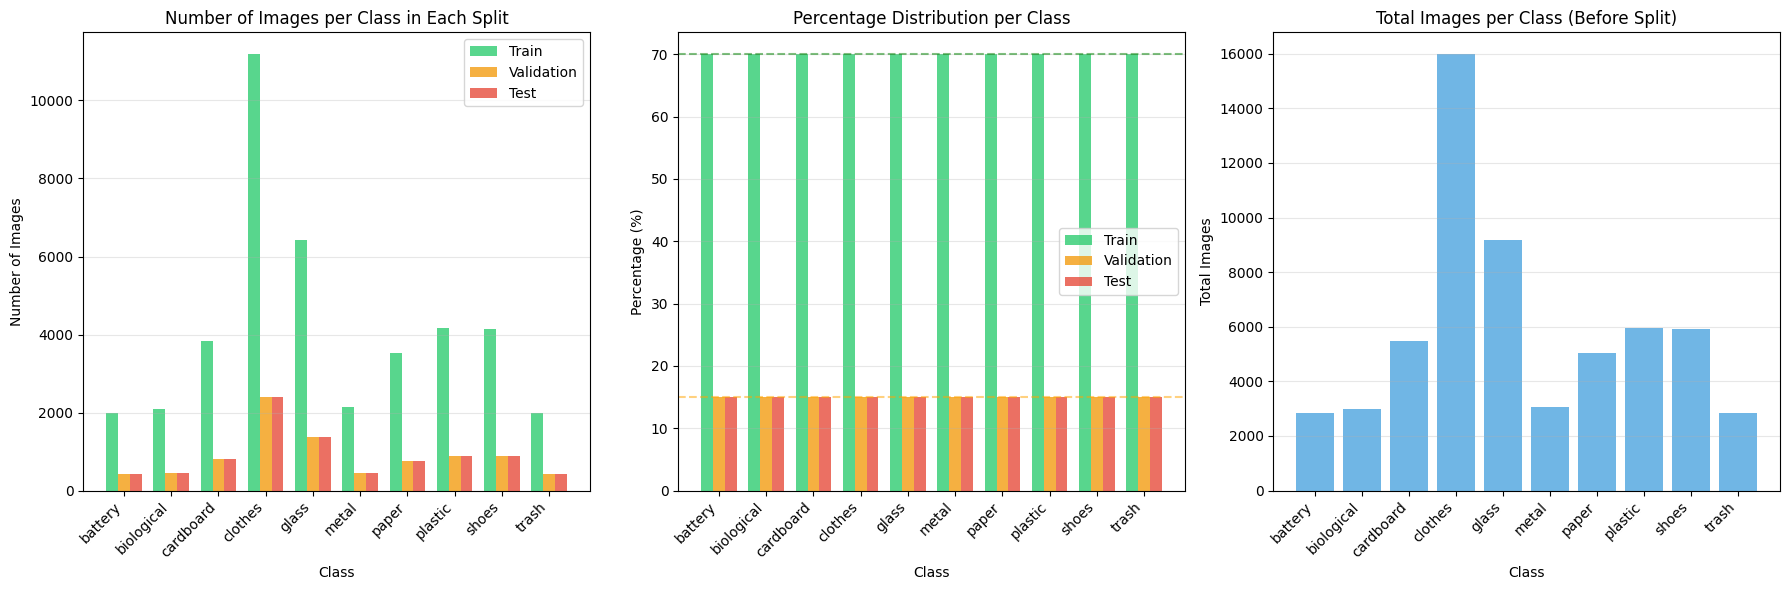


ĐƯỜNG DẪN CÁC TẬP DỮ LIỆU:
Train path:      /content/garbage-dataset-split/train
Validation path:  /content/garbage-dataset-split/validation
Test path:       /content/garbage-dataset-split/test


In [19]:
# Vẽ biểu đồ so sánh phân bố các lớp
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Biểu đồ số lượng ảnh
x = range(len(classes))
width = 0.25

axes[0].bar([i - width for i in x], split_df['Train'], width, label='Train', alpha=0.8, color='#2ecc71')
axes[0].bar(x, split_df['Validation'], width, label='Validation', alpha=0.8, color='#f39c12')
axes[0].bar([i + width for i in x], split_df['Test'], width, label='Test', alpha=0.8, color='#e74c3c')

axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Number of Images per Class in Each Split')
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Biểu đồ phần trăm
axes[1].bar([i - width for i in x], split_df['Train %'], width, label='Train', alpha=0.8, color='#2ecc71')
axes[1].bar(x, split_df['Val %'], width, label='Validation', alpha=0.8, color='#f39c12')
axes[1].bar([i + width for i in x], split_df['Test %'], width, label='Test', alpha=0.8, color='#e74c3c')

axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Percentage Distribution per Class')
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=70, color='green', linestyle='--', alpha=0.5, label='Target: 70%')
axes[1].axhline(y=15, color='orange', linestyle='--', alpha=0.5, label='Target: 15%')

# Biểu đồ tổng số lượng
total_by_class = split_df['Total'].values
axes[2].bar(x, total_by_class, alpha=0.7, color='#3498db')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Total Images')
axes[2].set_title('Total Images per Class (Before Split)')
axes[2].set_xticks(x)
axes[2].set_xticklabels(classes, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# In đường dẫn các tập
print("\n" + "=" * 70)
print("ĐƯỜNG DẪN CÁC TẬP DỮ LIỆU:")
print("=" * 70)
print(f"Train path:      {split_train_path}")
print(f"Validation path:  {split_val_path}")
print(f"Test path:       {split_test_path}")
print("=" * 70)


## 6. Xử lý mất cân bằng dữ liệu (Class Imbalance)

PHÂN TÍCH MẤT CÂN BẰNG DỮ LIỆU

Số lượng ảnh trong tập Train theo từng lớp:
            Count  Ratio_to_Max  Ratio_to_Mean
clothes     11186         100.0          269.6
glass        6426          57.4          154.9
plastic      4160          37.2          100.3
shoes        4151          37.1          100.1
cardboard    3832          34.3           92.4
paper        3528          31.5           85.0
metal        2142          19.1           51.6
biological   2093          18.7           50.4
trash        1988          17.8           47.9
battery      1982          17.7           47.8

THỐNG KÊ:
Lớp có nhiều ảnh nhất: clothes (11186 ảnh)
Lớp có ít ảnh nhất: battery (1982 ảnh)
Số lượng trung bình: 4149 ảnh
Số lượng trung vị: 3680 ảnh

Tỷ lệ chênh lệch: 5.64x
Lớp đa số (clothes) gấp 2.70x so với trung bình
Lớp thiểu số (battery) chỉ bằng 0.48x so với trung bình

⚠️ Lớp cần undersampling: clothes (11186 ảnh)
⚠️ Các lớp có thể cần oversampling: 4 lớp
   metal, biological, trash, battery


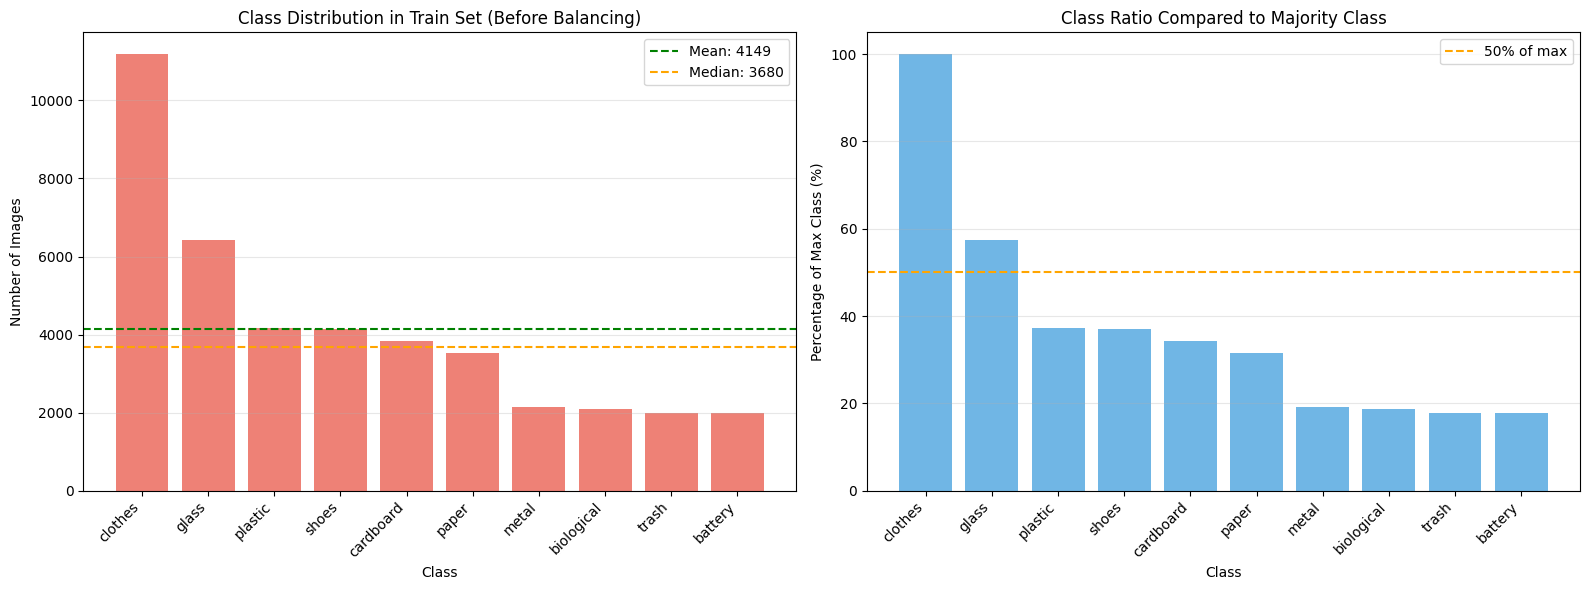

In [20]:
# Phân tích mất cân bằng dữ liệu
print("=" * 70)
print("PHÂN TÍCH MẤT CÂN BẰNG DỮ LIỆU")
print("=" * 70)

# Đếm số lượng ảnh trong tập train (tập quan trọng nhất)
train_class_counts = {}
for cls in classes:
    train_class_path = os.path.join(split_train_path, cls)
    if os.path.exists(train_class_path):
        count = len([f for f in os.listdir(train_class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
        train_class_counts[cls] = count
    else:
        train_class_counts[cls] = 0

# Tạo DataFrame
imbalance_df = pd.DataFrame({
    'Count': [train_class_counts[cls] for cls in classes]
}, index=classes)

# Tính toán các chỉ số
max_count = imbalance_df['Count'].max()
min_count = imbalance_df['Count'].min()
mean_count = imbalance_df['Count'].mean()
median_count = imbalance_df['Count'].median()

imbalance_df['Ratio_to_Max'] = (imbalance_df['Count'] / max_count * 100).round(1)
imbalance_df['Ratio_to_Mean'] = (imbalance_df['Count'] / mean_count * 100).round(1)
imbalance_df = imbalance_df.sort_values('Count', ascending=False)

print("\nSố lượng ảnh trong tập Train theo từng lớp:")
print(imbalance_df)

print("\n" + "=" * 70)
print("THỐNG KÊ:")
print("=" * 70)
print(f"Lớp có nhiều ảnh nhất: {imbalance_df.index[0]} ({max_count} ảnh)")
print(f"Lớp có ít ảnh nhất: {imbalance_df.index[-1]} ({min_count} ảnh)")
print(f"Số lượng trung bình: {mean_count:.0f} ảnh")
print(f"Số lượng trung vị: {median_count:.0f} ảnh")
print(f"\nTỷ lệ chênh lệch: {max_count / min_count:.2f}x")
print(f"Lớp đa số ({imbalance_df.index[0]}) gấp {max_count / mean_count:.2f}x so với trung bình")
print(f"Lớp thiểu số ({imbalance_df.index[-1]}) chỉ bằng {min_count / mean_count:.2f}x so với trung bình")

# Xác định lớp cần xử lý
majority_class = imbalance_df.index[0]
majority_count = max_count
minority_classes = imbalance_df[imbalance_df['Count'] < mean_count * 0.7].index.tolist()

print(f"\n⚠️ Lớp cần undersampling: {majority_class} ({majority_count} ảnh)")
print(f"⚠️ Các lớp có thể cần oversampling: {len(minority_classes)} lớp")
print(f"   {', '.join(minority_classes[:5])}{'...' if len(minority_classes) > 5 else ''}")

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ số lượng
axes[0].bar(range(len(classes)), imbalance_df['Count'].values, alpha=0.7, color='#e74c3c')
axes[0].axhline(y=mean_count, color='green', linestyle='--', label=f'Mean: {mean_count:.0f}')
axes[0].axhline(y=median_count, color='orange', linestyle='--', label=f'Median: {median_count:.0f}')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Class Distribution in Train Set (Before Balancing)')
axes[0].set_xticks(range(len(classes)))
axes[0].set_xticklabels(imbalance_df.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Biểu đồ tỷ lệ so với max
axes[1].bar(range(len(classes)), imbalance_df['Ratio_to_Max'].values, alpha=0.7, color='#3498db')
axes[1].axhline(y=50, color='orange', linestyle='--', label='50% of max')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage of Max Class (%)')
axes[1].set_title('Class Ratio Compared to Majority Class')
axes[1].set_xticks(range(len(classes)))
axes[1].set_xticklabels(imbalance_df.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [21]:
# Xử lý mất cân bằng dữ liệu: Undersampling + Oversampling
import random

def balance_dataset(source_train_path, source_val_path, source_test_path,
                    classes, target_count=None, random_state=42):
    """
    Cân bằng dataset bằng cách:
    1. Undersampling lớp đa số (clothes) xuống target_count
    2. Oversampling các lớp thiểu số lên target_count (nếu cần)

    Parameters:
    - source_train_path: Đường dẫn tập train gốc
    - source_val_path: Đường dẫn tập validation gốc
    - source_test_path: Đường dẫn tập test gốc
    - classes: Danh sách các lớp
    - target_count: Số lượng ảnh mục tiêu cho mỗi lớp (None = dùng median)
    - random_state: Seed để đảm bảo kết quả có thể tái tạo
    """
    random.seed(random_state)
    np.random.seed(random_state)

    # Tính target_count nếu không được chỉ định
    if target_count is None:
        train_counts = [len([f for f in os.listdir(os.path.join(source_train_path, cls))
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
                       for cls in classes]
        target_count = int(np.median(train_counts))
        print(f"Target count (median): {target_count} images per class")
    else:
        print(f"Target count (specified): {target_count} images per class")

    # Tạo thư mục output
    balanced_output_path = "/content/garbage-dataset-balanced"
    balanced_train_path = os.path.join(balanced_output_path, "train")
    balanced_val_path = os.path.join(balanced_output_path, "validation")
    balanced_test_path = os.path.join(balanced_output_path, "test")

    # Xóa thư mục cũ nếu tồn tại
    if os.path.exists(balanced_output_path):
        print(f"Removing existing balanced directory: {balanced_output_path}")
        shutil.rmtree(balanced_output_path)

    # Tạo thư mục mới
    os.makedirs(balanced_train_path, exist_ok=True)
    os.makedirs(balanced_val_path, exist_ok=True)
    os.makedirs(balanced_test_path, exist_ok=True)

    print(f"\nBalancing dataset...")
    print("=" * 70)

    total_train_original = 0
    total_train_balanced = 0
    total_val = 0
    total_test = 0

    for cls in classes:
        # Tạo thư mục cho từng tập
        train_class_path = os.path.join(balanced_train_path, cls)
        val_class_path = os.path.join(balanced_val_path, cls)
        test_class_path = os.path.join(balanced_test_path, cls)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Xử lý tập TRAIN
        source_train_class_path = os.path.join(source_train_path, cls)
        train_images = [f for f in os.listdir(source_train_class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        original_train_count = len(train_images)
        total_train_original += original_train_count

        if original_train_count > target_count:
            # UNDERSAMPLING: Chọn ngẫu nhiên target_count ảnh
            selected_train = random.sample(train_images, target_count)
            action = "UNDERSAMPLED"
        elif original_train_count < target_count:
            # OVERSAMPLING: Lặp lại ảnh cho đến khi đủ target_count
            # Tránh lặp lại quá nhiều, chỉ oversample đến 1.5x số lượng gốc
            max_oversample = int(original_train_count * 1.5)
            target = min(target_count, max_oversample)

            # Lặp lại danh sách ảnh
            oversampled = train_images * (target // original_train_count)
            remaining = target % original_train_count
            if remaining > 0:
                oversampled.extend(random.sample(train_images, remaining))
            selected_train = oversampled
            action = "OVERSAMPLED"
        else:
            # Không cần thay đổi
            selected_train = train_images
            action = "UNCHANGED"

        # Copy ảnh train đã được cân bằng
        for img_name in tqdm(selected_train, desc=f"  {cls} train ({action})", leave=False):
            src = os.path.join(source_train_class_path, img_name)
            dst = os.path.join(train_class_path, img_name)
            shutil.copy2(src, dst)
            total_train_balanced += 1

        # Xử lý tập VALIDATION và TEST (giữ nguyên, không cân bằng)
        # Validation
        source_val_class_path = os.path.join(source_val_path, cls)
        if os.path.exists(source_val_class_path):
            val_images = [f for f in os.listdir(source_val_class_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            for img_name in val_images:
                src = os.path.join(source_val_class_path, img_name)
                dst = os.path.join(val_class_path, img_name)
                shutil.copy2(src, dst)
                total_val += 1

        # Test
        source_test_class_path = os.path.join(source_test_path, cls)
        if os.path.exists(source_test_class_path):
            test_images = [f for f in os.listdir(source_test_class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            for img_name in test_images:
                src = os.path.join(source_test_class_path, img_name)
                dst = os.path.join(test_class_path, img_name)
                shutil.copy2(src, dst)
                total_test += 1

        print(f"{cls}: {original_train_count} → {len(selected_train)} train images ({action})")

    print("\n" + "=" * 70)
    print("BALANCING SUMMARY:")
    print("=" * 70)
    print(f"Train (original):  {total_train_original} images")
    print(f"Train (balanced): {total_train_balanced} images")
    print(f"Validation:       {total_val} images (unchanged)")
    print(f"Test:             {total_test} images (unchanged)")
    print(f"Reduction:        {total_train_original - total_train_balanced} images removed")
    print(f"Reduction %:      {(1 - total_train_balanced/total_train_original)*100:.1f}%")
    print("=" * 70)

    return balanced_train_path, balanced_val_path, balanced_test_path

# Thực hiện cân bằng dataset
# Sử dụng median làm target (có thể điều chỉnh)
balanced_train_path, balanced_val_path, balanced_test_path = balance_dataset(
    source_train_path=split_train_path,
    source_val_path=split_val_path,
    source_test_path=split_test_path,
    classes=classes,
    target_count=None,  # None = dùng median, hoặc chỉ định số cụ thể (ví dụ: 3000)
    random_state=42
)


Target count (median): 3680 images per class

Balancing dataset...


battery: 1982 → 2973 train images (OVERSAMPLED)


biological: 2093 → 3139 train images (OVERSAMPLED)


cardboard: 3832 → 3680 train images (UNDERSAMPLED)


clothes: 11186 → 3680 train images (UNDERSAMPLED)


glass: 6426 → 3680 train images (UNDERSAMPLED)


metal: 2142 → 3213 train images (OVERSAMPLED)


paper: 3528 → 3680 train images (OVERSAMPLED)


plastic: 4160 → 3680 train images (UNDERSAMPLED)


shoes: 4151 → 3680 train images (UNDERSAMPLED)


trash: 1988 → 2982 train images (OVERSAMPLED)

BALANCING SUMMARY:
Train (original):  41488 images
Train (balanced): 34387 images
Validation:       8891 images (unchanged)
Test:             8895 images (unchanged)
Reduction:        7101 images removed
Reduction %:      17.1%


KIỂM TRA KẾT QUẢ SAU KHI CÂN BẰNG

So sánh số lượng ảnh trong tập Train (Trước vs Sau):
            Before  After  Difference  Change %
clothes      11186   3680       -7506     -67.1
glass         6426   3680       -2746     -42.7
plastic       4160   3680        -480     -11.5
shoes         4151   3680        -471     -11.3
cardboard     3832   3680        -152      -4.0
paper         3528   3528           0       0.0
metal         2142   2142           0       0.0
biological    2093   2093           0       0.0
trash         1988   1988           0       0.0
battery       1982   1982           0       0.0

THỐNG KÊ SAU KHI CÂN BẰNG:
Lớp có nhiều ảnh nhất: clothes (3680 ảnh)
Lớp có ít ảnh nhất: battery (1982 ảnh)
Số lượng trung bình: 3013 ảnh
Độ lệch chuẩn: 830.5 ảnh

Tỷ lệ chênh lệch: 1.86x (trước: 5.64x)
Coefficient of Variation: 27.6% (càng nhỏ càng đều)


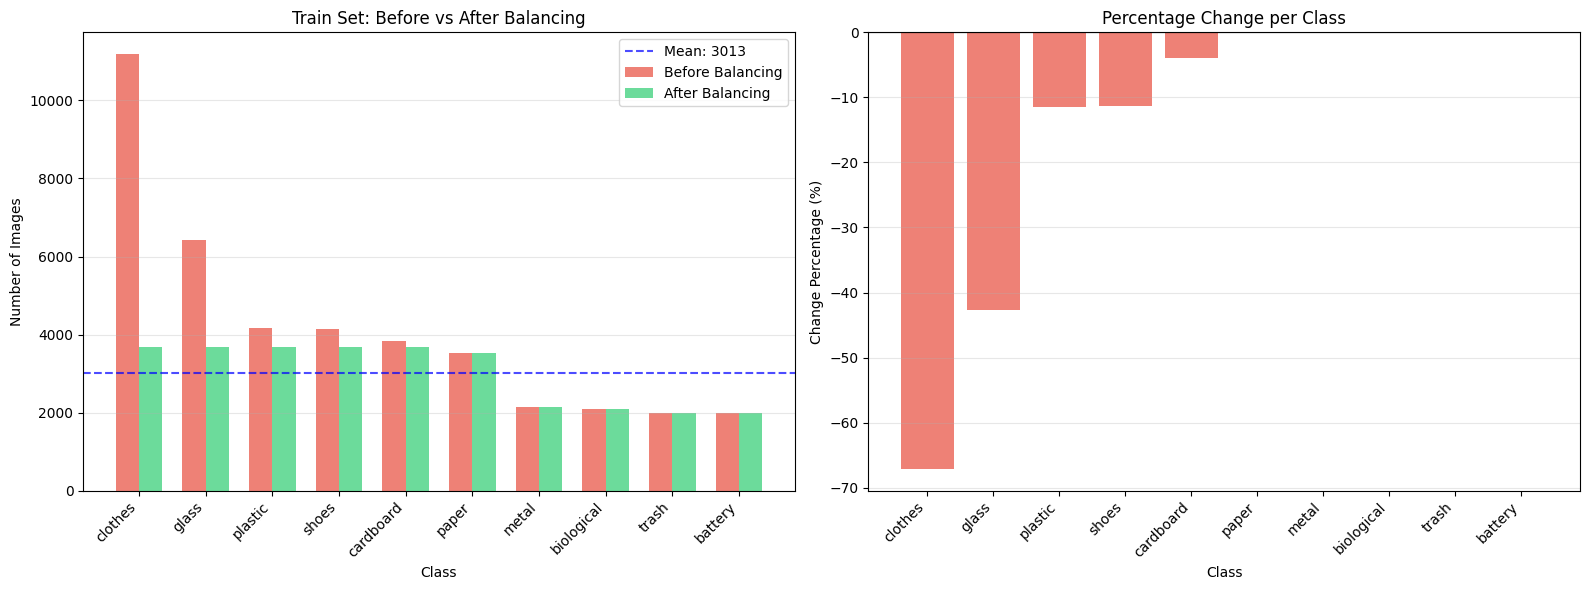


ĐƯỜNG DẪN CÁC TẬP DỮ LIỆU ĐÃ CÂN BẰNG:
Balanced Train path:      /content/garbage-dataset-balanced/train
Balanced Validation path:  /content/garbage-dataset-balanced/validation
Balanced Test path:       /content/garbage-dataset-balanced/test


In [22]:
# Kiểm tra kết quả sau khi cân bằng
print("=" * 70)
print("KIỂM TRA KẾT QUẢ SAU KHI CÂN BẰNG")
print("=" * 70)

# Đếm số lượng ảnh trong tập train đã cân bằng
balanced_train_counts = {}
for cls in classes:
    balanced_train_class_path = os.path.join(balanced_train_path, cls)
    if os.path.exists(balanced_train_class_path):
        count = len([f for f in os.listdir(balanced_train_class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
        balanced_train_counts[cls] = count
    else:
        balanced_train_counts[cls] = 0

# Tạo DataFrame so sánh
comparison_df = pd.DataFrame({
    'Before': [train_class_counts[cls] for cls in classes],
    'After': [balanced_train_counts[cls] for cls in classes]
}, index=classes)

comparison_df['Difference'] = comparison_df['After'] - comparison_df['Before']
comparison_df['Change %'] = (comparison_df['Difference'] / comparison_df['Before'] * 100).round(1)
comparison_df = comparison_df.sort_values('Before', ascending=False)

print("\nSo sánh số lượng ảnh trong tập Train (Trước vs Sau):")
print(comparison_df)

# Tính toán các chỉ số sau khi cân bằng
balanced_max = comparison_df['After'].max()
balanced_min = comparison_df['After'].min()
balanced_mean = comparison_df['After'].mean()
balanced_std = comparison_df['After'].std()

print("\n" + "=" * 70)
print("THỐNG KÊ SAU KHI CÂN BẰNG:")
print("=" * 70)
print(f"Lớp có nhiều ảnh nhất: {comparison_df['After'].idxmax()} ({balanced_max} ảnh)")
print(f"Lớp có ít ảnh nhất: {comparison_df['After'].idxmin()} ({balanced_min} ảnh)")
print(f"Số lượng trung bình: {balanced_mean:.0f} ảnh")
print(f"Độ lệch chuẩn: {balanced_std:.1f} ảnh")
print(f"\nTỷ lệ chênh lệch: {balanced_max / balanced_min:.2f}x (trước: {max_count / min_count:.2f}x)")
print(f"Coefficient of Variation: {(balanced_std / balanced_mean * 100):.1f}% (càng nhỏ càng đều)")

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ so sánh trước/sau
x = range(len(classes))
width = 0.35

axes[0].bar([i - width/2 for i in x], comparison_df['Before'], width,
            label='Before Balancing', alpha=0.7, color='#e74c3c')
axes[0].bar([i + width/2 for i in x], comparison_df['After'], width,
            label='After Balancing', alpha=0.7, color='#2ecc71')
axes[0].axhline(y=balanced_mean, color='blue', linestyle='--',
                label=f'Mean: {balanced_mean:.0f}', alpha=0.7)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Train Set: Before vs After Balancing')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Biểu đồ phần trăm thay đổi
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in comparison_df['Change %']]
axes[1].bar(x, comparison_df['Change %'], alpha=0.7, color=colors)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Change Percentage (%)')
axes[1].set_title('Percentage Change per Class')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df.index, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# In đường dẫn
print("\n" + "=" * 70)
print("ĐƯỜNG DẪN CÁC TẬP DỮ LIỆU ĐÃ CÂN BẰNG:")
print("=" * 70)
print(f"Balanced Train path:      {balanced_train_path}")
print(f"Balanced Validation path:  {balanced_val_path}")
print(f"Balanced Test path:       {balanced_test_path}")
print("=" * 70)


## 7. Setup Training Environment

In [23]:
# Setup Training Environment
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import random
from collections import defaultdict

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("=" * 70)
print("TRAINING ENVIRONMENT SETUP")
print("=" * 70)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ GPU not available, using CPU (training will be slower)")

# Set random seeds để đảm bảo kết quả có thể tái tạo
def set_seed(seed=42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print(f"\nRandom seed set to: 42 (for reproducibility)")

# Kiểm tra PyTorch version
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

# Kiểm tra số lượng classes
print(f"\nNumber of classes: {len(classes)}")
print(f"Classes: {classes}")

print("=" * 70)


TRAINING ENVIRONMENT SETUP
Device: cuda
GPU: Tesla T4
CUDA Version: 12.6
GPU Memory: 14.74 GB

Random seed set to: 42 (for reproducibility)
PyTorch Version: 2.9.0+cu126
Torchvision Version: 0.24.0+cu126

Number of classes: 10
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


## 8. Data Preparation for Training

In [24]:
# Tạo Transforms cho Training và Validation/Test
print("=" * 70)
print("DATA PREPARATION - TRANSFORMS")
print("=" * 70)

# Normalization stats cho CNN từ đầu (không dùng ImageNet stats)
# Sử dụng normalize về [-1, 1] từ [0, 1]
DATASET_MEAN = [0.5, 0.5, 0.5]
DATASET_STD = [0.5, 0.5, 0.5]

# Giữ biến IMAGENET_MEAN/STD cho denormalize function (nếu cần)
IMAGENET_MEAN = DATASET_MEAN
IMAGENET_STD = DATASET_STD

# Transform cho TRAINING (có augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize lớn hơn một chút
    transforms.RandomCrop(224),    # Random crop về 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang
    transforms.RandomRotation(degrees=15),   # Xoay ±15 độ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),  # Chuyển sang tensor [0, 1]
    transforms.Normalize(mean=DATASET_MEAN, std=DATASET_STD)  # Normalize về [-1, 1]
])

# Transform cho VALIDATION và TEST (không augmentation, chỉ resize và normalize)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize về 224x224
    transforms.ToTensor(),  # Chuyển sang tensor [0, 1]
    transforms.Normalize(mean=DATASET_MEAN, std=DATASET_STD)  # Normalize về [-1, 1]
])

print("Train Transform:")
print("  - Resize(256) → RandomCrop(224)")
print("  - RandomHorizontalFlip(p=0.5)")
print("  - RandomRotation(±15°)")
print("  - ColorJitter")
print("  - ToTensor()")
print("  - Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) → [-1, 1]")

print("\nValidation/Test Transform:")
print("  - Resize(224)")
print("  - ToTensor()")
print("  - Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) → [-1, 1]")
print("\nNote: Using simple normalization for CNN trained from scratch")

# Kiểm tra đường dẫn dataset đã cân bằng
if 'balanced_train_path' in globals():
    dataset_path = balanced_train_path
    print(f"\n✓ Using balanced dataset: {dataset_path}")
else:
    # Fallback về split dataset nếu chưa có balanced
    if 'split_train_path' in globals():
        dataset_path = split_train_path
        print(f"\n⚠️ Using split dataset (not balanced): {dataset_path}")
    else:
        print("\n❌ Error: No dataset path found. Please run data balancing first.")
        dataset_path = None

print("=" * 70)


DATA PREPARATION - TRANSFORMS
Train Transform:
  - Resize(256) → RandomCrop(224)
  - RandomHorizontalFlip(p=0.5)
  - RandomRotation(±15°)
  - ColorJitter
  - ToTensor()
  - Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) → [-1, 1]

Validation/Test Transform:
  - Resize(224)
  - ToTensor()
  - Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) → [-1, 1]

Note: Using simple normalization for CNN trained from scratch

✓ Using balanced dataset: /content/garbage-dataset-balanced/train


In [25]:
# Tạo Datasets và DataLoaders
print("=" * 70)
print("CREATING DATASETS AND DATALOADERS")
print("=" * 70)

# Kiểm tra đường dẫn
if 'balanced_train_path' in globals() and os.path.exists(balanced_train_path):
    train_path = balanced_train_path
    val_path = balanced_val_path
    test_path = balanced_test_path
    print("Using balanced dataset")
elif 'split_train_path' in globals() and os.path.exists(split_train_path):
    train_path = split_train_path
    val_path = split_val_path
    test_path = split_test_path
    print("Using split dataset (not balanced)")
else:
    raise ValueError("Dataset paths not found. Please run data preparation cells first.")

# Tạo datasets
print(f"\nLoading datasets...")
print(f"Train path: {train_path}")
print(f"Validation path: {val_path}")
print(f"Test path: {test_path}")

try:
    train_dataset = ImageFolder(root=train_path, transform=train_transform)
    val_dataset = ImageFolder(root=val_path, transform=val_test_transform)
    test_dataset = ImageFolder(root=test_path, transform=val_test_transform)

    print(f"\n✓ Datasets created successfully!")
    print(f"  Train samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")

    # Kiểm tra class names và mapping
    print(f"\nClass names: {train_dataset.classes}")
    print(f"Class to index mapping: {train_dataset.class_to_idx}")

    # Lưu số lượng classes
    num_classes = len(train_dataset.classes)
    print(f"\nNumber of classes: {num_classes}")

except Exception as e:
    print(f"❌ Error creating datasets: {str(e)}")
    raise

print("=" * 70)


CREATING DATASETS AND DATALOADERS
Using balanced dataset

Loading datasets...
Train path: /content/garbage-dataset-balanced/train
Validation path: /content/garbage-dataset-balanced/validation
Test path: /content/garbage-dataset-balanced/test

✓ Datasets created successfully!
  Train samples: 30133
  Validation samples: 8891
  Test samples: 8895

Class names: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Class to index mapping: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}

Number of classes: 10


In [26]:
# Tạo DataLoaders
print("=" * 70)
print("CREATING DATALOADERS")
print("=" * 70)

# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 4  # Số worker cho data loading (0 nếu có lỗi)

print(f"Batch size: {BATCH_SIZE}")
print(f"Number of workers: {NUM_WORKERS}")

# Tạo DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle cho training
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,  # Tăng tốc nếu có GPU
    drop_last=True  # Bỏ batch cuối nếu không đủ
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Không shuffle cho validation
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Không shuffle cho test
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ DataLoaders created successfully!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Kiểm tra một batch
print(f"\nTesting DataLoader...")
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"  Batch shape: {images.shape}")  # [batch_size, channels, height, width]
print(f"  Labels shape: {labels.shape}")  # [batch_size]
print(f"  Image dtype: {images.dtype}")
print(f"  Label dtype: {labels.dtype}")
print(f"  Image range: [{images.min():.3f}, {images.max():.3f}]")

print("=" * 70)


CREATING DATALOADERS
Batch size: 32
Number of workers: 4

✓ DataLoaders created successfully!
  Train batches: 941
  Validation batches: 278
  Test batches: 278

Testing DataLoader...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Batch shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])
  Image dtype: torch.float32
  Label dtype: torch.int64
  Image range: [-1.000, 1.000]


VISUALIZING SAMPLE IMAGES FROM DATALOADER


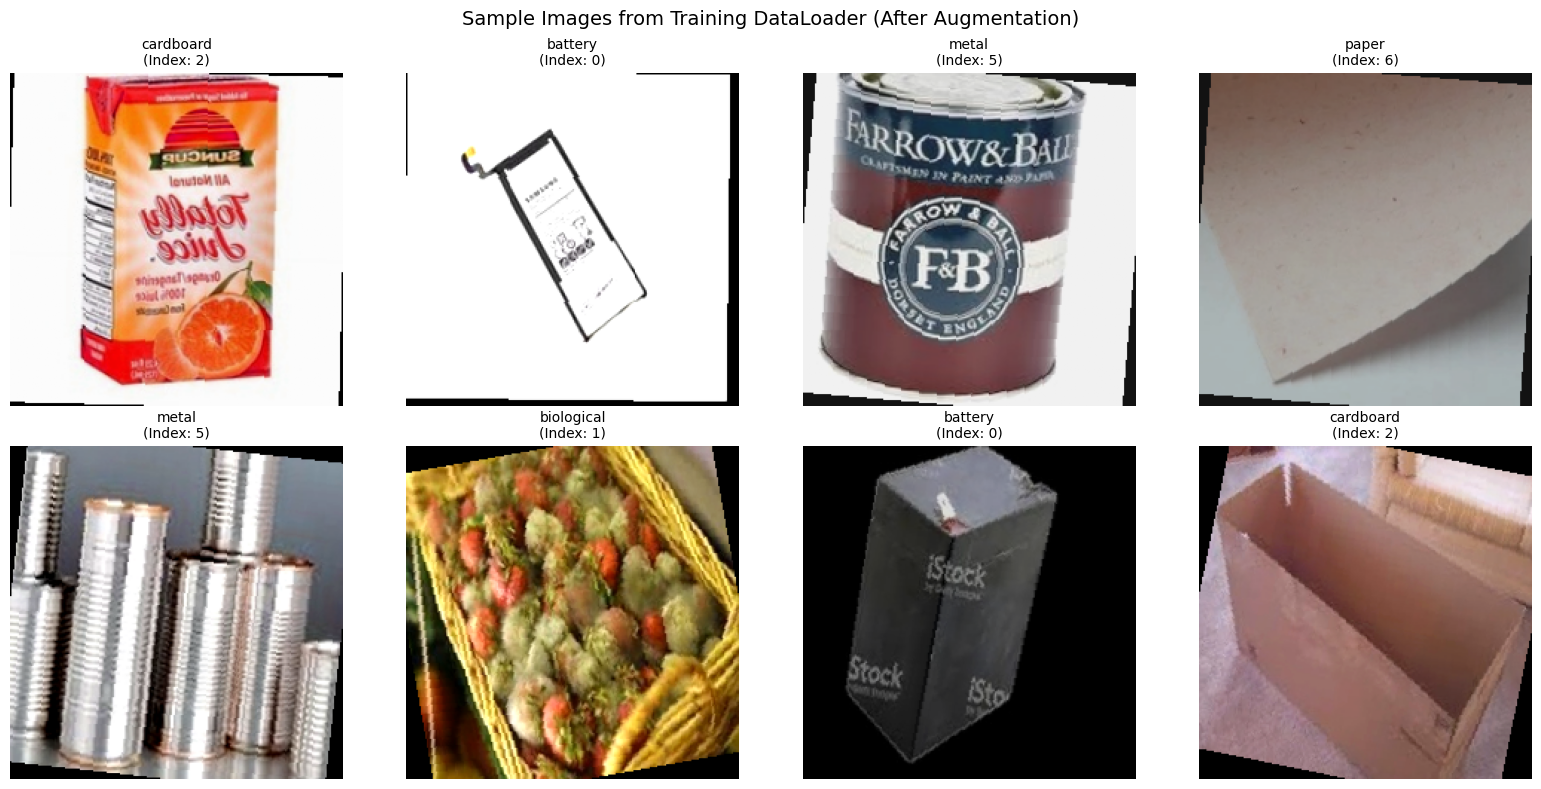


✓ Sample images displayed successfully!
  Each image is 224x224, normalized to [-1, 1]
  Augmentation is applied to training images


In [27]:
# Hiển thị một số mẫu ảnh từ DataLoader
print("=" * 70)
print("VISUALIZING SAMPLE IMAGES FROM DATALOADER")
print("=" * 70)

def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Denormalize tensor để hiển thị"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)

def imshow(tensor, title=""):
    """Hiển thị tensor như ảnh"""
    # Denormalize
    img = denormalize(tensor.clone())
    img = img.permute(1, 2, 0)  # [C, H, W] → [H, W, C]
    img = img.cpu().numpy()

    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Lấy một batch từ train_loader
sample_batch = next(iter(train_loader))
images, labels = sample_batch

# Hiển thị 8 ảnh đầu tiên
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, len(images))):
    img = images[i]
    label_idx = labels[i].item()
    label_name = train_dataset.classes[label_idx]

    axes[i].imshow(denormalize(img.clone()).permute(1, 2, 0).cpu().numpy())
    axes[i].set_title(f"{label_name}\n(Index: {label_idx})", fontsize=10)
    axes[i].axis('off')

plt.suptitle("Sample Images from Training DataLoader (After Augmentation)", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n✓ Sample images displayed successfully!")
print(f"  Each image is 224x224, normalized to [-1, 1]")
print(f"  Augmentation is applied to training images")

print("=" * 70)


## 9. Model Definition - Custom CNN from Scratch

In [28]:
# Tạo Custom CNN từ đầu cho phân loại rác thải
print("=" * 70)
print("MODEL DEFINITION - Custom CNN from Scratch")
print("=" * 70)

class GarbageClassifier(nn.Module):
    """
    Custom CNN architecture cho phân loại rác thải
    Architecture: 4 Conv Blocks + Global Average Pooling + 2 FC layers
    """
    def __init__(self, num_classes=10):
        super(GarbageClassifier, self).__init__()

        # Feature extractor - 4 Conv Blocks
        self.features = nn.Sequential(
            # Block 1: 224x224 → 112x112
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),

            # Block 2: 112x112 → 56x56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),

            # Block 3: 56x56 → 28x28
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),

            # Block 4: 28x28 → 14x14
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.4),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling: 14x14 → 1x1
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            # Removed BatchNorm1d - not needed in FC layers and causes issues with batch_size=1
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Tạo model
model = GarbageClassifier(num_classes=num_classes)
print("✓ Created custom CNN model from scratch")

# Weight initialization
def init_weights(m):
    """Khởi tạo weights tốt cho training từ đầu"""
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

model.apply(init_weights)
print("✓ Applied weight initialization (Kaiming for Conv, Xavier for Linear)")

# Di chuyển model lên GPU nếu có
model = model.to(device)
print(f"✓ Model moved to {device}")

# Đếm số parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB (float32)")

# Hiển thị architecture
print(f"\nModel Architecture:")
print(model)

# Test forward pass
print(f"\nTesting forward pass...")
model.eval()  # Set to eval mode to avoid BatchNorm issues with batch_size=1
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f"  Input shape: {dummy_input.shape}")
print(f"  Output shape: {output.shape}")
print(f"  ✓ Forward pass successful!")
model.train()  # Set back to train mode for training

print("=" * 70)

MODEL DEFINITION - Custom CNN from Scratch
✓ Created custom CNN model from scratch
✓ Applied weight initialization (Kaiming for Conv, Xavier for Linear)
✓ Model moved to cuda

Model Statistics:
  Total parameters: 4,823,114
  Trainable parameters: 4,823,114
  Model size: ~18.40 MB (float32)

Model Architecture:
GarbageClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

## 10. Training Setup

In [29]:
# Setup Loss Function, Optimizer, và Learning Rate Scheduler
print("=" * 70)
print("TRAINING SETUP")
print("=" * 70)

# Loss Function - CrossEntropyLoss (phù hợp cho multi-class classification)
criterion = nn.CrossEntropyLoss()
print(f"✓ Loss function: CrossEntropyLoss")

# Optimizer - Adam với weight decay để tránh overfitting
# Learning rate cao hơn cho training từ đầu
LEARNING_RATE = 1e-3  # Tăng từ 1e-4 lên 1e-3 cho training từ đầu
WEIGHT_DECAY = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
print(f"✓ Optimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE} (higher for training from scratch)")
print(f"  Weight decay: {WEIGHT_DECAY}")

# Learning Rate Scheduler - CosineAnnealingLR (phù hợp cho training từ đầu)
# Giảm learning rate theo cosine schedule
NUM_EPOCHS = 20  # Số epochs để train tiếp
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,  # Số epochs
    eta_min=1e-6  # Learning rate tối thiểu
)
print(f"✓ Learning rate scheduler: CosineAnnealingLR")
print(f"  T_max: {NUM_EPOCHS} epochs")
print(f"  Eta_min: 1e-6")
print(f"  → Learning rate sẽ giảm từ {LEARNING_RATE} xuống 1e-6 theo cosine curve")
EARLY_STOPPING_PATIENCE = 5  # Dừng nếu không cải thiện trong 5 epochs
EARLY_STOPPING_MIN_DELTA = 0.1  # Cải thiện tối thiểu 0.1% để coi là có cải thiện

print(f"\nTraining Parameters:")
print(f"  Number of epochs: {NUM_EPOCHS} (increased for training from scratch)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Device: {device}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE} epochs")
print(f"  Early stopping min delta: {EARLY_STOPPING_MIN_DELTA}%")
print(f"\nNote: Training from scratch requires more epochs and higher learning rate")

# Lưu best model
best_val_loss = float('inf')
best_val_acc = 0.0
best_model_path = "/content/best_garbage_classifier.pth"

# Early stopping variables
no_improve_count = 0  # Đếm số epochs không cải thiện

# Lưu training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

print("=" * 70)

TRAINING SETUP
✓ Loss function: CrossEntropyLoss
✓ Optimizer: Adam
  Learning rate: 0.001 (higher for training from scratch)
  Weight decay: 0.0001
✓ Learning rate scheduler: CosineAnnealingLR
  T_max: 20 epochs
  Eta_min: 1e-6
  → Learning rate sẽ giảm từ 0.001 xuống 1e-6 theo cosine curve

Training Parameters:
  Number of epochs: 20 (increased for training from scratch)
  Batch size: 32
  Device: cuda
  Early stopping patience: 5 epochs
  Early stopping min delta: 0.1%

Note: Training from scratch requires more epochs and higher learning rate


## 11. Training Functions

In [30]:
# Định nghĩa các hàm training và validation
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train model trong một epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for images, labels in progress_bar:
        # Di chuyển dữ liệu lên device
        images = images.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Tính accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update loss
        running_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validating")
        for images, labels in progress_bar:
            # Di chuyển dữ liệu lên device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Tính accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update loss
            running_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

print("✓ Training functions defined")
print("  - train_one_epoch(): Train model trong một epoch")
print("  - validate(): Validate model")


✓ Training functions defined
  - train_one_epoch(): Train model trong một epoch
  - validate(): Validate model


## 11.5. Load Checkpoint (Resume Training)


In [ ]:
# Load Checkpoint để tiếp tục training
print("=" * 70)
print("LOADING CHECKPOINT TO RESUME TRAINING")
print("=" * 70)

# Đường dẫn đến checkpoint
checkpoint_path = "/content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth"

# Khởi tạo biến mặc định (nếu không có checkpoint)
start_epoch = 0
best_val_acc = 0.0
best_val_loss = float('inf')

# Kiểm tra xem có checkpoint không
if os.path.exists(checkpoint_path):
    print(f"✓ Checkpoint found at: {checkpoint_path}")

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Model state loaded from checkpoint")

    # Load optimizer state (nếu có)
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("✓ Optimizer state loaded from checkpoint")

    # Lấy thông tin từ checkpoint
    start_epoch = checkpoint.get('epoch', 0)
    best_val_acc = checkpoint.get('val_acc', 0.0)
    best_val_loss = checkpoint.get('val_loss', float('inf'))

    print(f"\nCheckpoint Information:")
    print(f"  Epoch: {start_epoch}")
    print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"  Best Validation Loss: {best_val_loss:.4f}")

    # Tính số epochs sẽ train (train thêm NUM_EPOCHS epochs từ start_epoch)
    target_epoch = start_epoch + NUM_EPOCHS
    remaining_epochs = NUM_EPOCHS  # Số epochs sẽ train thêm

    # Tạo scheduler mới với T_max = NUM_EPOCHS (số epochs sẽ train)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=remaining_epochs,  # Số epochs sẽ train thêm
        eta_min=1e-6
    )
    print(f"✓ Scheduler updated for {remaining_epochs} additional epochs")
    print(f"  Will train from epoch {start_epoch + 1} to epoch {target_epoch}")

    # Khôi phục training history (nếu có)
    if 'history' in checkpoint:
        history = checkpoint['history']
        print("✓ Training history loaded from checkpoint")
    else:
        print("⚠️ No history in checkpoint, will continue with new history")
        # Giữ nguyên history đã khởi tạo

    # Reset early stopping counter
    no_improve_count = 0

    print(f"\n✓ Ready to resume training from epoch {start_epoch + 1}")

else:
    print(f"⚠️ No checkpoint found at {checkpoint_path}")
    print("Starting training from scratch...")
    start_epoch = 0
    best_val_acc = 0.0
    best_val_loss = float('inf')
    # Giữ nguyên history đã khởi tạo

print("=" * 70)


LOADING CHECKPOINT TO RESUME TRAINING
✓ Checkpoint found at: /content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth
✓ Model state loaded from checkpoint
✓ Optimizer state loaded from checkpoint

Checkpoint Information:
  Epoch: 39
  Best Validation Accuracy: 84.07%
  Best Validation Loss: 0.4966
✓ Scheduler updated for 20 additional epochs
  Will train from epoch 40 to epoch 59
⚠️ No history in checkpoint, will continue with new history

✓ Ready to resume training from epoch 40


## 12. Model Training

In [ ]:
# Training Loop
print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)
print(f"Model: Custom CNN (from scratch)")
print(f"Dataset: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")
print(f"Device: {device}")
print(f"Epochs: {NUM_EPOCHS}")
print("=" * 70)

start_time = time.time()

# Nếu resume từ checkpoint, start_epoch đã được set ở cell trước
# Nếu train từ đầu, start_epoch = 0 (mặc định)
if 'start_epoch' not in locals():
    start_epoch = 0
    best_val_acc = 0.0
    best_val_loss = float('inf')

# Tính target epoch: train thêm NUM_EPOCHS epochs từ start_epoch
target_epoch = start_epoch + NUM_EPOCHS
initial_history_length = len(history['train_loss'])  # Lưu độ dài history ban đầu
print(f"Training from epoch {start_epoch + 1} to epoch {target_epoch} (total: {NUM_EPOCHS} epochs)")

for epoch in range(start_epoch, target_epoch):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{target_epoch} (Progress: {epoch+1-start_epoch}/{NUM_EPOCHS} new epochs)")
    print(f"{'='*70}")

    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Learning rate scheduling (CosineAnnealingLR - không cần val_loss)
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step()  # CosineAnnealingLR không cần metric
    current_lr = optimizer.param_groups[0]['lr']

    # In thông báo nếu learning rate thay đổi
    if abs(current_lr - old_lr) > 1e-7:
        print(f"  📉 Learning rate: {old_lr:.2e} → {current_lr:.2e}")

    # Lưu history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)

    # In kết quả
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.2e}")

    # Lưu best model (dựa trên validation accuracy)
    # Kiểm tra xem có cải thiện đáng kể không (>= min_delta)
    improvement = val_acc - best_val_acc

    if val_acc > best_val_acc:
        # Có cải thiện
        if improvement >= EARLY_STOPPING_MIN_DELTA:
            # Cải thiện đáng kể -> reset counter
            no_improve_count = 0
            print(f"  ✓ Significant improvement: +{improvement:.2f}%")
        else:
            # Cải thiện nhỏ (< min_delta) -> reset counter (vẫn coi là có tiến bộ)
            no_improve_count = 0
            print(f"  ✓ Minor improvement: +{improvement:.2f}% (saved, but < {EARLY_STOPPING_MIN_DELTA}% threshold)")

        # Luôn lưu model nếu có cải thiện
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'num_classes': num_classes,
            'class_names': train_dataset.classes,
            'history': history  # Lưu training history
        }, best_model_path)
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        # Không có cải thiện (val_acc <= best_val_acc)
        no_improve_count += 1
        print(f"  ⚠️ No improvement (Best: {best_val_acc:.2f}%, Current: {val_acc:.2f}%)")
        print(f"  ⚠️ No improvement count: {no_improve_count}/{EARLY_STOPPING_PATIENCE}")

    # Early stopping
    if no_improve_count >= EARLY_STOPPING_PATIENCE:
        print(f"\n{'='*70}")
        print("EARLY STOPPING TRIGGERED")
        print(f"{'='*70}")
        print(f"No improvement for {EARLY_STOPPING_PATIENCE} consecutive epochs")
        print(f"Best validation accuracy: {best_val_acc:.2f}% (at epoch {epoch + 1 - EARLY_STOPPING_PATIENCE})")
        print(f"Stopping training at epoch {epoch + 1}/{NUM_EPOCHS}")
        print("=" * 70)
        break

total_time = time.time() - start_time
print(f"\n{'='*70}")
print("TRAINING COMPLETED")
print(f"{'='*70}")
# Tính số epochs mới đã train
new_epochs_trained = len(history['train_loss']) - initial_history_length
print(f"Total epochs trained in this session: {new_epochs_trained}/{NUM_EPOCHS}")
print(f"Total epochs (including previous): {len(history['train_loss'])}")
if no_improve_count >= EARLY_STOPPING_PATIENCE:
    print(f"Training stopped early due to no improvement")
else:
    print(f"Training completed all {NUM_EPOCHS} additional epochs")
print(f"Total training time: {total_time/60:.2f} minutes ({total_time/3600:.2f} hours)")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best model saved to: {best_model_path}")
print("=" * 70)


STARTING TRAINING
Model: Custom CNN (from scratch)
Dataset: 30133 train, 8891 val, 8895 test
Device: cuda
Epochs: 20
Training from epoch 40 to epoch 59 (total: 20 epochs)

Epoch 40/59 (Progress: 1/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.81it/s, loss=1.0325, acc=82.76%]


  📉 Learning rate: 2.74e-04 → 2.72e-04

Epoch 40 Summary:
  Train Loss: 0.7517 | Train Acc: 75.45%
  Val Loss:   0.5199 | Val Acc:   82.76%
  Learning Rate: 2.72e-04
  ⚠️ No improvement (Best: 84.07%, Current: 82.76%)
  ⚠️ No improvement count: 1/5

Epoch 41/59 (Progress: 2/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.80it/s, loss=1.0139, acc=84.15%]


  📉 Learning rate: 2.72e-04 → 2.67e-04

Epoch 41 Summary:
  Train Loss: 0.7494 | Train Acc: 75.23%
  Val Loss:   0.4805 | Val Acc:   84.15%
  Learning Rate: 2.67e-04
  ✓ Minor improvement: +0.08% (saved, but < 0.1% threshold)
  ✓ New best model saved! (Val Acc: 84.15%)

Epoch 42/59 (Progress: 3/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.82it/s, loss=0.9567, acc=83.74%]


  📉 Learning rate: 2.67e-04 → 2.59e-04

Epoch 42 Summary:
  Train Loss: 0.7286 | Train Acc: 75.96%
  Val Loss:   0.4837 | Val Acc:   83.74%
  Learning Rate: 2.59e-04
  ⚠️ No improvement (Best: 84.15%, Current: 83.74%)
  ⚠️ No improvement count: 1/5

Epoch 43/59 (Progress: 4/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.84it/s, loss=1.0374, acc=83.44%]


  📉 Learning rate: 2.59e-04 → 2.48e-04

Epoch 43 Summary:
  Train Loss: 0.7263 | Train Acc: 76.19%
  Val Loss:   0.4969 | Val Acc:   83.44%
  Learning Rate: 2.48e-04
  ⚠️ No improvement (Best: 84.15%, Current: 83.44%)
  ⚠️ No improvement count: 2/5

Epoch 44/59 (Progress: 5/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.76it/s, loss=1.1432, acc=84.31%]


  📉 Learning rate: 2.48e-04 → 2.34e-04

Epoch 44 Summary:
  Train Loss: 0.7075 | Train Acc: 76.87%
  Val Loss:   0.4702 | Val Acc:   84.31%
  Learning Rate: 2.34e-04
  ✓ Significant improvement: +0.16%
  ✓ New best model saved! (Val Acc: 84.31%)

Epoch 45/59 (Progress: 6/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.80it/s, loss=1.1198, acc=85.58%]


  📉 Learning rate: 2.34e-04 → 2.18e-04

Epoch 45 Summary:
  Train Loss: 0.6901 | Train Acc: 77.55%
  Val Loss:   0.4277 | Val Acc:   85.58%
  Learning Rate: 2.18e-04
  ✓ Significant improvement: +1.27%
  ✓ New best model saved! (Val Acc: 85.58%)

Epoch 46/59 (Progress: 7/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.81it/s, loss=0.7644, acc=85.40%]


  📉 Learning rate: 2.18e-04 → 1.99e-04

Epoch 46 Summary:
  Train Loss: 0.6851 | Train Acc: 77.65%
  Val Loss:   0.4396 | Val Acc:   85.40%
  Learning Rate: 1.99e-04
  ⚠️ No improvement (Best: 85.58%, Current: 85.40%)
  ⚠️ No improvement count: 1/5

Epoch 47/59 (Progress: 8/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.78it/s, loss=0.9781, acc=85.04%]


  📉 Learning rate: 1.99e-04 → 1.80e-04

Epoch 47 Summary:
  Train Loss: 0.6585 | Train Acc: 78.37%
  Val Loss:   0.4504 | Val Acc:   85.04%
  Learning Rate: 1.80e-04
  ⚠️ No improvement (Best: 85.58%, Current: 85.04%)
  ⚠️ No improvement count: 2/5

Epoch 48/59 (Progress: 9/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.77it/s, loss=0.9953, acc=85.65%]


  📉 Learning rate: 1.80e-04 → 1.59e-04

Epoch 48 Summary:
  Train Loss: 0.6520 | Train Acc: 78.58%
  Val Loss:   0.4327 | Val Acc:   85.65%
  Learning Rate: 1.59e-04
  ✓ Minor improvement: +0.07% (saved, but < 0.1% threshold)
  ✓ New best model saved! (Val Acc: 85.65%)

Epoch 49/59 (Progress: 10/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.80it/s, loss=0.9387, acc=87.11%]


  📉 Learning rate: 1.59e-04 → 1.37e-04

Epoch 49 Summary:
  Train Loss: 0.6361 | Train Acc: 79.11%
  Val Loss:   0.3985 | Val Acc:   87.11%
  Learning Rate: 1.37e-04
  ✓ Significant improvement: +1.46%
  ✓ New best model saved! (Val Acc: 87.11%)

Epoch 50/59 (Progress: 11/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.83it/s, loss=0.8108, acc=87.25%]


  📉 Learning rate: 1.37e-04 → 1.16e-04

Epoch 50 Summary:
  Train Loss: 0.6244 | Train Acc: 79.52%
  Val Loss:   0.3901 | Val Acc:   87.25%
  Learning Rate: 1.16e-04
  ✓ Significant improvement: +0.13%
  ✓ New best model saved! (Val Acc: 87.25%)

Epoch 51/59 (Progress: 12/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.82it/s, loss=0.9006, acc=87.38%]


  📉 Learning rate: 1.16e-04 → 9.52e-05

Epoch 51 Summary:
  Train Loss: 0.6102 | Train Acc: 80.09%
  Val Loss:   0.3863 | Val Acc:   87.38%
  Learning Rate: 9.52e-05
  ✓ Significant improvement: +0.13%
  ✓ New best model saved! (Val Acc: 87.38%)

Epoch 52/59 (Progress: 13/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.84it/s, loss=0.9886, acc=87.80%]


  📉 Learning rate: 9.52e-05 → 7.55e-05

Epoch 52 Summary:
  Train Loss: 0.5919 | Train Acc: 80.47%
  Val Loss:   0.3763 | Val Acc:   87.80%
  Learning Rate: 7.55e-05
  ✓ Significant improvement: +0.42%
  ✓ New best model saved! (Val Acc: 87.80%)

Epoch 53/59 (Progress: 14/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.78it/s, loss=0.9162, acc=88.24%]


  📉 Learning rate: 7.55e-05 → 5.72e-05

Epoch 53 Summary:
  Train Loss: 0.5835 | Train Acc: 80.99%
  Val Loss:   0.3603 | Val Acc:   88.24%
  Learning Rate: 5.72e-05
  ✓ Significant improvement: +0.44%
  ✓ New best model saved! (Val Acc: 88.24%)

Epoch 54/59 (Progress: 15/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.82it/s, loss=0.9689, acc=88.12%]


  📉 Learning rate: 5.72e-05 → 4.09e-05

Epoch 54 Summary:
  Train Loss: 0.5761 | Train Acc: 81.08%
  Val Loss:   0.3650 | Val Acc:   88.12%
  Learning Rate: 4.09e-05
  ⚠️ No improvement (Best: 88.24%, Current: 88.12%)
  ⚠️ No improvement count: 1/5

Epoch 55/59 (Progress: 16/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.78it/s, loss=0.8783, acc=88.54%]


  📉 Learning rate: 4.09e-05 → 2.70e-05

Epoch 55 Summary:
  Train Loss: 0.5691 | Train Acc: 81.42%
  Val Loss:   0.3525 | Val Acc:   88.54%
  Learning Rate: 2.70e-05
  ✓ Significant improvement: +0.30%
  ✓ New best model saved! (Val Acc: 88.54%)

Epoch 56/59 (Progress: 17/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.80it/s, loss=0.8702, acc=88.58%]


  📉 Learning rate: 2.70e-05 → 1.59e-05

Epoch 56 Summary:
  Train Loss: 0.5498 | Train Acc: 81.92%
  Val Loss:   0.3512 | Val Acc:   88.58%
  Learning Rate: 1.59e-05
  ✓ Minor improvement: +0.04% (saved, but < 0.1% threshold)
  ✓ New best model saved! (Val Acc: 88.58%)

Epoch 57/59 (Progress: 18/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.80it/s, loss=0.9163, acc=88.65%]


  📉 Learning rate: 1.59e-05 → 7.67e-06

Epoch 57 Summary:
  Train Loss: 0.5485 | Train Acc: 82.17%
  Val Loss:   0.3498 | Val Acc:   88.65%
  Learning Rate: 7.67e-06
  ✓ Minor improvement: +0.07% (saved, but < 0.1% threshold)
  ✓ New best model saved! (Val Acc: 88.65%)

Epoch 58/59 (Progress: 19/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.83it/s, loss=0.9414, acc=88.71%]


  📉 Learning rate: 7.67e-06 → 2.68e-06

Epoch 58 Summary:
  Train Loss: 0.5433 | Train Acc: 82.14%
  Val Loss:   0.3461 | Val Acc:   88.71%
  Learning Rate: 2.68e-06
  ✓ Minor improvement: +0.06% (saved, but < 0.1% threshold)
  ✓ New best model saved! (Val Acc: 88.71%)

Epoch 59/59 (Progress: 20/20 new epochs)


Validating: 100%|██████████| 278/278 [00:35<00:00,  7.80it/s, loss=0.8673, acc=88.42%]

  📉 Learning rate: 2.68e-06 → 1.00e-06

Epoch 59 Summary:
  Train Loss: 0.5401 | Train Acc: 82.40%
  Val Loss:   0.3496 | Val Acc:   88.42%
  Learning Rate: 1.00e-06
  ⚠️ No improvement (Best: 88.71%, Current: 88.42%)
  ⚠️ No improvement count: 1/5

TRAINING COMPLETED
Total epochs trained in this session: 20/20
Total epochs (including previous): 20
Training completed all 20 additional epochs
Total training time: 135.14 minutes (2.25 hours)
Best validation accuracy: 88.71%
Best validation loss: 0.3461
Best model saved to: /content/best_garbage_classifier.pth


## 13. Save Model to Google Drive

In [ ]:
print("=" * 70)
print("SAVING MODEL TO GOOGLE DRIVE")
print("=" * 70)

# Đường dẫn trong Google Drive
drive_model_path = "/content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth"

# Tạo thư mục nếu chưa tồn tại
drive_dir = os.path.dirname(drive_model_path)
os.makedirs(drive_dir, exist_ok=True)

# Copy model từ local sang Google Drive
if os.path.exists(best_model_path):
    print(f"Copying model from: {best_model_path}")
    print(f"To Google Drive: {drive_model_path}")

    # Copy file
    shutil.copy2(best_model_path, drive_model_path)

    # Kiểm tra file size
    file_size = os.path.getsize(drive_model_path) / (1024 * 1024)  # MB
    print(f"\n✓ Model saved successfully to Google Drive!")
    print(f"  File size: {file_size:.2f} MB")
    print(f"  Location: {drive_model_path}")

    # Verify file exists
    if os.path.exists(drive_model_path):
        print("  ✓ File verified in Google Drive")
    else:
        print("  ⚠️ Warning: File not found in Google Drive")
else:
    print(f"❌ Error: Model file not found at {best_model_path}")
    print("Please ensure training has completed successfully.")

print("=" * 70)


SAVING MODEL TO GOOGLE DRIVE
Copying model from: /content/best_garbage_classifier.pth
To Google Drive: /content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth

✓ Model saved successfully to Google Drive!
  File size: 55.26 MB
  Location: /content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth
  ✓ File verified in Google Drive


## 14. Test Model với 100 ảnh và Trực quan hóa

In [31]:
print("=" * 70)
print("TESTING MODEL WITH 100 IMAGES")
print("=" * 70)

# Load model từ Google Drive
drive_model_path = "/content/drive/MyDrive/NAM4/HMUD/garbage_classifier_model.pth"
print("Loading model from Google Drive...")
print(f"  Model path: {drive_model_path}")

if os.path.exists(drive_model_path):
    checkpoint = torch.load(drive_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    print(f"✓ Model loaded successfully from Google Drive!")
    print(f"  Best validation accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"  Best validation loss: {checkpoint['val_loss']:.4f}")
else:
    print(f"❌ Error: Model file not found at {drive_model_path}")
    print("Please ensure the model has been saved to Google Drive first.")
    raise FileNotFoundError(f"Model file not found: {drive_model_path}")

# Lấy 100 ảnh ngẫu nhiên từ test set
print(f"\nSelecting 100 random images from test set...")
test_indices = random.sample(range(len(test_dataset)), 100)
test_images = []
test_labels = []
test_paths = []

for idx in test_indices:
    image, label = test_dataset[idx]
    test_images.append(image)
    test_labels.append(label)
    # Lấy đường dẫn ảnh gốc
    img_path, _ = test_dataset.samples[idx]
    test_paths.append(img_path)

# Chuyển thành batch tensor
test_batch = torch.stack(test_images).to(device)
test_labels_tensor = torch.tensor(test_labels).to(device)

# Dự đoán
print("Making predictions...")
with torch.no_grad():
    outputs = model(test_batch)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_probs, predicted_classes = torch.max(probabilities, dim=1)

# Chuyển về CPU để hiển thị
predicted_classes = predicted_classes.cpu().numpy()
predicted_probs = predicted_probs.cpu().numpy()
test_labels_np = np.array(test_labels)

# Tính accuracy
correct = (predicted_classes == test_labels_np).sum()
accuracy = 100 * correct / len(test_labels_np)

print(f"✓ Predictions completed!")
print(f"  Accuracy on 100 test images: {accuracy:.1f}% ({correct}/100)")

# Trực quan hóa kết quả
print("\nVisualizing results...")
fig, axes = plt.subplots(10, 10, figsize=(25, 25))
axes = axes.flatten()

for i in range(100):
    # Load ảnh gốc (chưa normalize) để hiển thị
    img_original = Image.open(test_paths[i])

    # Hiển thị ảnh
    axes[i].imshow(img_original)

    # Lấy thông tin
    true_label_idx = test_labels_np[i]
    pred_label_idx = predicted_classes[i]
    confidence = predicted_probs[i] * 100

    true_label = test_dataset.classes[true_label_idx]
    pred_label = test_dataset.classes[pred_label_idx]

    # Màu sắc: xanh nếu đúng, đỏ nếu sai
    color = 'green' if true_label_idx == pred_label_idx else 'red'
    title = f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)\n"

    if true_label_idx == pred_label_idx:
        title += "✓ CORRECT"
    else:
        title += "✗ WRONG"

    axes[i].set_title(title, fontsize=7, color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle(f"Model Predictions on 100 Test Images (Accuracy: {accuracy:.1f}%)",
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Hiển thị chi tiết từng ảnh
print("\n" + "=" * 70)
print("DETAILED RESULTS:")
print("=" * 70)
for i in range(100):
    true_label_idx = test_labels_np[i]
    pred_label_idx = predicted_classes[i]
    confidence = predicted_probs[i] * 100

    true_label = test_dataset.classes[true_label_idx]
    pred_label = test_dataset.classes[pred_label_idx]

    status = "✓" if true_label_idx == pred_label_idx else "✗"
    print(f"{i+1:3d}. {status} True: {true_label:12s} | Pred: {pred_label:12s} | Confidence: {confidence:5.1f}%")

print("=" * 70)
print(f"\nSummary: {correct}/100 correct ({accuracy:.1f}%)")
print("=" * 70)


Output hidden; open in https://colab.research.google.com to view.

## 15. Predict từ ảnh người dùng import

PREDICTING FROM USER-PROVIDED IMAGE URL
✓ Image downloaded successfully.


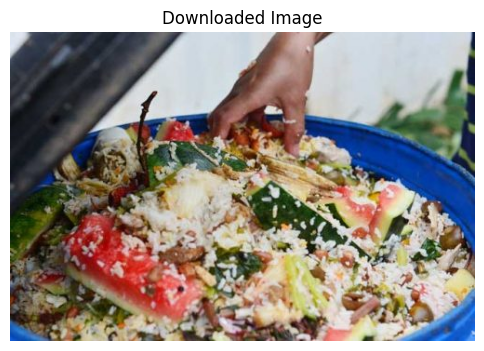

In [36]:
import requests
from io import BytesIO

print("=" * 70)
print("PREDICTING FROM USER-PROVIDED IMAGE URL")
print("=" * 70)

# @title Enter Image URL and Run
image_url = "https://thonghutbephottaivinhphuc.com/wp-content/uploads/2017/11/-%C4%83n-th%E1%BB%ABa-e1511751185586.jpg" # @param {type:"string"}

if image_url == "https://example.com/your_image.jpg" or not image_url:
    print("Vui lòng nhập URL ảnh để dự đoán.")
else:
    print(f"Downloading image from: {image_url}")
    try:
        response = requests.get(image_url)
        response.raise_for_status() # Raise an exception for HTTP errors
        img = Image.open(BytesIO(response.content))
        print("✓ Image downloaded successfully.")

        # Hiển thị ảnh vừa tải về
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title("Downloaded Image")
        plt.axis('off')
        plt.show()

    except requests.exceptions.RequestException as e:
        print(f"❌ Error downloading image: {e}")
        img = None
    except Exception as e:
        print(f"❌ Error processing image from URL: {e}")
        img = None
print("=" * 70)


In [37]:
if 'img' in locals() and img is not None:
    print("=" * 70)
    print("PREPROCESSING AND PREDICTING")
    print("=" * 70)

    # Áp dụng transform
    input_tensor = val_test_transform(img).unsqueeze(0) # Thêm batch dimension
    input_tensor = input_tensor.to(device)

    # Chuyển model sang chế độ đánh giá
    model.eval()

    # Dự đoán
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Lấy kết quả dự đoán
    predicted_prob, predicted_idx = torch.max(probabilities, dim=1)
    predicted_class = train_dataset.classes[predicted_idx.item()]

    print(f"✓ Prediction complete!")
    print(f"  Predicted Class: {predicted_class}")
    print(f"  Confidence: {predicted_prob.item()*100:.2f}%")

    # Tùy chọn: Hiển thị top-5 predictions
    top_p, top_class_idx = probabilities.topk(5, dim=1)
    top_p = top_p.squeeze().cpu().numpy()
    top_class_idx = top_class_idx.squeeze().cpu().numpy()

    print("\nTop 5 Predictions:")
    for i in range(len(top_p)):
        class_name = train_dataset.classes[top_class_idx[i]]
        print(f"  - {class_name}: {top_p[i]*100:.2f}%")

    print("=" * 70)
else:
    print("Không có ảnh để xử lý. Vui lòng kiểm tra URL ảnh.")


PREPROCESSING AND PREDICTING
✓ Prediction complete!
  Predicted Class: biological
  Confidence: 83.06%

Top 5 Predictions:
  - biological: 83.06%
  - paper: 9.31%
  - trash: 2.83%
  - shoes: 1.22%
  - clothes: 0.94%
